In [1]:
# !pip install numpy
# !pip install scipy
# !pip install torch
# !pip install matplotlib
#!pip install scikit-learn

In [2]:
import torch
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [3]:
# Use smaller network for testing - ex 2000 neurons
# Even for the project, doing it for 10^6 neurons would take too long
# Problem this creates: test network is denser than actual network b/c we have 10^3 neurons but 10^2 connections per neuron
num_neurons = 2000
num_i = int(0.1 * num_neurons)
num_e = int(0.9 * num_neurons)

# Num excitatory inputs and inhibitory inputs to each neuron (in reality it should be 500 but we reduce it here to make things faster)
k = 100

# Number of olfactory bulb channels (glomeruli) to each neuron
D = 10 ** 3
# For each neuron, how many glomeruli inputs it receives (should be 10^2)
num_channel_inputs = 100

# Number of odors
P = 16
# Novel activity is up to P // 2, and familiar activity is after
novel_inds = torch.arange(0, P // 2)
familiar_inds = torch.arange(P // 2, P)

In [4]:
# Creates adjacency matrix with the given probability of edge connection and size mxn
# Remove sparse functionality for now
def create_adj_matrix(p, m, n):
    # num_connections = int(p * m * n)
    # # This creates possibility of multiple indices being sampled, so better to just use torch bernoulli
    # m_coords = torch.randint(0, m, (num_connections,))
    # n_coords = torch.randint(0, n, (num_connections,))
    # indices = torch.vstack((m_coords, n_coords))
    # values = torch.ones(num_connections)
    # A_mn = torch.sparse_coo_tensor(indices, values, (m, n))
    probs = torch.ones(m, n) * p
    A_mn = torch.bernoulli(probs)
    return A_mn

In [5]:
# Draws mitral activity from exponential distribution (by default the rate is 1 / f, so the mean becomes f)
# Otherwise this exponential distribution drops off too quickly
# def compute_mitral_activity(rate=1/f):
#     # Generate new sample for each odor
#     dist = torch.distributions.Exponential(rate).expand(torch.Size([D]))
#     probs = dist.sample(sample_shape=(P,))
#     probs.t_()
#     probs[probs > 1] = 1
#     I = torch.bernoulli(probs) * (i_1 - i_0) + i_0
#     return I

In [6]:
# Epsilon value defining correlation amount between odors, e < 1, e=0.5
# def correlated_mitral_activity(e):
#     # Covariance matrix representing initial correlations between odors
#     Sigma_0 = torch.ones((P, P)) * e
#     # Each odor has variance 1 (the diagonal represents variances)
#     Sigma_0.fill_diagonal_(1)
#     dist = torch.distributions.MultivariateNormal(torch.zeros(P), Sigma_0)
#     activity = dist.sample(torch.Size([D]))
#     return activity

In [7]:
# New way of generating correlations between odors: we want different sets of odors to be correlated differently, so that when we subtract each neuron's mean activity over odors, it doesn't cancel out the variation between odors (if all the odors are correlated the same, they will tend to produce similar values for a single neuron and therefore subtracting by the mean will remove these values and only leave small fluctuations)
# So we sample a small set of odors P' and make them linearly independent, and then by multiplying by a P'x P gaussian matrix we project into mitral cell activity space for all P odors, basically making the P odors a linear combination of the set of P' odors (the smaller P' is, the more correlated the resulting set of P odors will be)
# We also scale the variance depending on how small P' is, so we will maintain differently correlated odors, just with higher total correlation if P' is small

In [8]:
P_prime = 4
def correlated_mitral_activity():
    # Each of the P' odors is independent (correlation of 0)
    sigma_p_prime = torch.zeros((P_prime, P_prime)).fill_diagonal_(1)
    dist = torch.distributions.MultivariateNormal(torch.zeros(P_prime), sigma_p_prime)
    p_prime_activity = dist.sample(torch.Size([D]))
    var = 1 / P_prime
    projection = torch.normal(torch.zeros((P_prime, P)), torch.ones(P_prime, P) * np.sqrt(var))
    activity = p_prime_activity @ projection
    return activity

In [9]:
# Draws random activity with probability f
# def compute_random_mitral_activity():
#     I = torch.distributions.Bernoulli(f).sample(torch.Size((D, P))) * (i_1 - i_0) + i_0
#     
#     return I

In [10]:
# Takes in mitral activity I and computes feedforward activity h_bar_ff
def compute_feedforward_activity(I):
    # Probability that a channel weight will be nonzero
    p = num_channel_inputs / D
    # Only the first 0.9 * n rows should have this bernoulli number, the rest should be 0 b/c they don't receive a channel input
    # Check whether each neuron still receives ~10^2 nonzero inputs or what the distribution actually looks like
    # Because when we calculate the adjacency matrix we don't go by row (e.g ensuring each neuron has these ~10^2 connections)
    # Alternative: sample from Binomial distribution w/ mean 100
    # The output n for each row is the number of nonzero inputs, and you choose a random subset n of the indices for that row and make them 1
    a = create_adj_matrix(p, num_e, D)
    # Inhibitory neurons don't receive channel input
    # This is the first simplification, where we neglect the first inhibitory layer I_ff
    b = torch.zeros(size=(num_i, D))
    W_ff = torch.cat(tensors=(a, b), dim=0)
    
    h_ff = (W_ff @ I) * (1 / np.sqrt(num_channel_inputs))
    h_bar_ff = h_ff - torch.mean(h_ff, dim=0, keepdim=True)
    return h_bar_ff

In [11]:
def compute_initial_recurrent_weights():
    k_ee = k_ei = k_ie = k_ii = k
    #p_ee = k_ee / num_e
    # k inhibitory inputs to that e neuron, out of num_i total inhibitory neurons gives the connection probability per neuron
    p_ei = k_ei / num_i
    p_ie = k_ie / num_e
    #p_ii = k_ii / num_i
    
    # Constants
    #w_ee = 0.1
    w_ei = 0.2
    w_ie = 0.5
    #w_ii = 0.3
    # Ignore ee and ii weights for now:
    p_ee = p_ii = w_ee = w_ii = 0
    W_ee = create_adj_matrix(p_ee, num_e, num_e) * w_ee
    W_ei = create_adj_matrix(p_ei, num_e, num_i) * -w_ei
    W_ie = create_adj_matrix(p_ie, num_i, num_e) * w_ie
    W_ii = create_adj_matrix(p_ii, num_i, num_i) * -w_ii
    
    
    # Concat
    W_1 = torch.cat(tensors=(W_ee, W_ei), dim=1)
    W_2 = torch.cat(tensors=(W_ie, W_ii), dim=1)
    W_rec = torch.cat(tensors=(W_1, W_2), dim=0)

    
    return W_rec

In [12]:
# Computes activation threshold for neurons, based on the standard deviation of their firing rates across odors
# This average standard deviation, multiplied by theta=2, ensures that each neuron will fire for only 5% of odors
def compute_threshold(total_input, theta):
    # For now, use diff thresholds for each neuron
    center = torch.mean(total_input, dim=1, keepdim=True)
    shift = torch.std(total_input, dim=1, keepdim=True)
    threshold = center + (theta * shift)
    # Since inhibitory neurons are linear
    threshold[num_e:, :] = 0
    return threshold

In [13]:
# ReLU for excitatory, linear for inhibitory
def neuron_activations(X):
    # Mask to keep excitatory
    mask1 = torch.ones((num_neurons, 1))
    mask1[num_e:, :] = 0
    # Mask to keep inhibitory
    mask2 = torch.zeros((num_neurons, 1))
    mask2[num_e:, :] = 1
    return (torch.relu(X) * mask1) + (X * mask2)

In [14]:
# Computes R for each odor, with the activation threshold theta
def compute_piriform_response(h_bar_ff, W_rec, threshold_mult):
    # The coefficient of x_bar
    tau = 1
    # time step
    dt = 0.1
    # Number of time steps
    T = 200
    
    # Initial condition where states are gaussian
    mu_0 = 0.
    sigma_0 = 0.2
    X_0 = torch.normal(mu_0, sigma_0, size=(num_neurons, P))
    X = X_0
    
    pts = []
    for i in range(T-1):
        with torch.no_grad():
            part1 = -1 * X
            part2 = (W_rec @ neuron_activations(X)) * (1 / np.sqrt(k))
            part3 = h_bar_ff
            dXdt = (1 / tau) * (part1 + part2 + part3)
            X = X + (dXdt * dt)
        # Look at convergence pattern for first odor, assuming that it'll
        # be similar across odors (since they are all independent)
        #pts.append(torch.mean(dXdt, dim=0)[0].item())
   
    # On the last iteration only, track the gradient
    X.requires_grad_(True)
    
    part1 = -1 * X
    part2 = (W_rec @ neuron_activations(X)) * (1 / np.sqrt(k))
    part3 = h_bar_ff
    with torch.no_grad():
        # The total input to the neuron at this last time step (should be equivalent to the resulting value of X after this time step, since dxdt = 0 after the recurrent network converges)
        total_input = part2 + part3
        threshold = compute_threshold(total_input, threshold_mult)
    
    dXdt = (1 / tau) * (part1 + part2 + part3)
    X = X + (dXdt * dt)
    # Plot derivatives to see if state converged
    # plt.plot(torch.arange(T-1), pts)
    # plt.show()
    R = neuron_activations(X - threshold)
    
    return R

In [15]:
# Compute dimensionality of activity matrix R for either novel or familiar
# def compute_dim(R, odor_inds):
#     # Only compute for the excitatory neurons (b/c those are the ones that send signals to rest of brain
#     C = torch.cov(R[:num_e, odor_inds[0]:odor_inds[-1]])
#     dim = torch.trace(C) ** 2 / torch.trace(C @ C)
#     return dim

In [16]:
import torch.nn as nn
import torch.optim as optim

def create_model() -> torch.nn.Sequential:
    # Number of neurons in hidden layer
    hidden_size = 100
    model = nn.Sequential(
        nn.Linear(2, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, 1),
    )
    
    return model

In [17]:
# Start and stop indices for the section of W_rec we want to update, respectively 
# Takes in R_alpha, a vector of neuron responses to a particular odor
def compute_update(model: torch.nn.Sequential, R_alpha: torch.Tensor, update_inds) -> torch.Tensor:
    # Compute the same pairs of R_i and R_j for every odor
    # 1D vectors of the pre and postsynaptic neurons corresponding to the nonzero weights of W_rec
    postsyn_responses = R_alpha[update_inds[0]]
    presyn_responses = R_alpha[update_inds[1]]
    model_input = torch.vstack((presyn_responses, postsyn_responses)).t()
    slice_updates = model(model_input)
    
    updates = slice_updates.squeeze(dim=1)
    
    return updates

In [18]:
def odor_corrs(R):
    # We don't care about the actual responses per odor, just about a neuron's fluctuations around its mean response across odors
    R_adjusted = R - torch.mean(R, dim=1, keepdim=True)
    # Each odor becomes a variable, because we want to calculate correlations between them across neurons
    R_adjusted.t_()
    # Like cov but divides by standard deviations, effectively normalizing the values (the diagonals of the resulting matrix become 1)
    sigma_E = torch.corrcoef(R_adjusted)
    # We only care about the correlations between the familiar odors
    familiar_corrs = sigma_E[P//2:P, P//2:P] - torch.eye(P // 2)
    corr_sum = torch.sum(familiar_corrs ** 2)
    avg_corr = torch.mean(torch.abs(familiar_corrs))
    
    return corr_sum, avg_corr

In [19]:
# Sparsity per odor, across all (E) neurons
def sparsity_per_odor(R):
    sp_per_odor = 1 - ((torch.sum(R[:num_e], dim=0) ** 2) / (num_e * (torch.sum(R[:num_e] ** 2, dim=0))))
    return sp_per_odor

# Sparsity per (E) neuron, across a given odor family
def sparsity_per_neuron(R, odor_inds):
    sp_per_neuron = 1 - ((torch.sum(R[:num_e, odor_inds], dim=1) ** 2) / (P * torch.sum(R[:num_e, odor_inds] ** 2, dim=1)))
    return sp_per_neuron

In [20]:
# Try to minimize the correlations between values
def loss_fn(R, lambda_corr, lambda_mu, lambda_var, lambda_sp):
    corr_sum, avg_corr = odor_corrs(R)
    corr_loss = (1 / P) * corr_sum
    corr_term = lambda_corr * corr_loss
    
    # means = torch.mean(R, dim=0)
    # means_novel = torch.mean(means[novel_inds])
    # means_familiar = torch.mean(means[familiar_inds])
    # mu_term = lambda_mu * (((means_familiar - means_novel) / (means_novel + means_familiar)) ** 2)
    mu_term = 0
    
    # vars = torch.var(R, dim=0)
    # var_novel = torch.mean(vars[novel_inds])
    # var_familiar = torch.mean(vars[familiar_inds])
    # var_term = lambda_var * (((var_familiar - var_novel) / (var_novel + var_familiar)) ** 2)
    var_term = 0
    
    # TODO sparsity was nan, meaning that sparsity_per_odor was nan for one of them and there were a set of E neurons which didn't respond at all, so sparsity denominator was 0
    # sparsities = sparsity_per_odor(R)
    # spars_novel = torch.mean(sparsities[novel_inds])
    # spars_familiar = torch.mean(sparsities[familiar_inds])
    # spars_term = lambda_sp * (((spars_familiar - spars_novel) / (spars_novel + spars_familiar)) ** 2)
    spars_term = 0
    
    print("Avg Corr: %.4f, Corr: %.4f, Mu: %.4f, Var: %.4f, Sparsity: %.4f" % (avg_corr, corr_term, mu_term, var_term, spars_term))
    loss = corr_term + mu_term + var_term + spars_term
    return loss

In [21]:
# Detaching vs zero grad - should detach because we have a term dependent on the previous model iteration which isn't zero but some constant gradient, accumulated from that model output

In [22]:
# Upper bound for weight matrix (most weights become 10x-15x initial value if they take the naive approach of increasing inhibition)
mult = 100
w_ei = -0.2
min_weight = mult * w_ei

def loss_after_odors(model: torch.nn.Sequential, W_rec: torch.Tensor, R_current: torch.Tensor, h_bar_ff: torch.Tensor, threshold_mult, plasticity_rate, weight_decay_rate, update_inds, lambda_corr, lambda_mu, lambda_var, lambda_sp, detach_grad=True, with_loss=False):
   # First, compute the respective weight updates through the novel and familiar odors from the current neural responses (which are from the current weight matrix)
    
    #updates = W_rec[update_inds].detach().clone()
    #updates.requires_grad_(True)
    updates = torch.zeros_like(W_rec[update_inds], requires_grad=True)
    W_rec.requires_grad_(True)
   
    # Remove shuffle for now
    for i in torch.randperm(P):
        ou = compute_update(model, R_current[:, i], update_inds)
        odor_update = ou
        # At the very end, we accumulate into W_rec so we need to check whether the new W_rec value at the very end will fit within max_weight
        with torch.no_grad():
            val_tensor = ((1 - plasticity_rate * weight_decay_rate) * W_rec[update_inds]) + updates + (plasticity_rate * odor_update)
            # I->E weights are only negative
            condition = torch.logical_and(torch.gt(val_tensor, min_weight), torch.le(val_tensor, 0.))
        normed_update = torch.where(condition, odor_update, 0.)
        updates = updates + normed_update
    

    updates = plasticity_rate * (updates - weight_decay_rate * W_rec[update_inds])

    W_rec = torch.index_put(W_rec, update_inds, updates, accumulate=True)
    
    R = compute_piriform_response(h_bar_ff, W_rec, threshold_mult)
    R_new = R
    
    if detach_grad:
        # We want a new R response tensor which only has the previous weight update but not anything before that
        W_rec = W_rec.detach()
        R_new = compute_piriform_response(h_bar_ff, W_rec, threshold_mult)

    
    if with_loss:
        loss = loss_fn(R, lambda_corr, lambda_mu, lambda_var, lambda_sp)
    else:
        loss = 0
    
    return loss, W_rec, R_new

In [23]:
# def loss_per_odor(W_rec: torch.Tensor, R_current: torch.Tensor, h_bar_ff: torch.Tensor):
#     W_rec.requires_grad_(True)
#     
#     W_rec = weight_update(W_rec, R_current, (num_e, num_neurons), (0, num_e))
#     
#     # Then find the updated neural responses from the updated weight matrix
#     R_new = compute_piriform_response(h_bar_ff, W_rec, theta)
#     
#     # Then, compute the loss, which is the ratio of the novel and familiar dimensionalities
#     loss = loss_fn(R_new)
#    
#     # We want a new R response tensor which only has the previous weight update but not anything before that
#     W_static = W_rec.detach().clone()
#     R_tosend = compute_piriform_response(h_bar_ff, W_static, theta)
#    
#     
#     return loss, W_rec, R_tosend

In [24]:
# To check theoretical minimum odor correlations, generate random gaussian matrix of shape (num_neurons, 8) and this is what the minimum correlation should be
# mu = torch.zeros((num_neurons, 16))
# std = torch.ones((num_neurons, 16))
# R_random = torch.normal(mu, std)
# loss_min = loss_fn(R_random)
# Theoretical min of 0.05

In [25]:
def verify_initial_activities():
    runs = 100
    avg_corrs = torch.empty((runs,))
    total_losses = torch.empty((runs,))
    for i in range(runs):
        with torch.no_grad():
            a = correlated_mitral_activity()
            h = compute_feedforward_activity(a)
            w = compute_initial_recurrent_weights()
            r = compute_piriform_response(h, w, 0)
        R_adjusted = r - torch.mean(r, dim=1, keepdim=True)
        R_adjusted.t_()
        sigma_E = torch.corrcoef(R_adjusted)
        familiar_corrs = sigma_E[P//2:P, P//2:P] - torch.eye(P // 2)
        total_loss = torch.sum(familiar_corrs ** 2)
        avg_corr = torch.mean(torch.abs(familiar_corrs))
        print(f"Loss: {total_loss.item()}, Avg Corr: {avg_corr}")
        total_losses[i] = total_loss
        avg_corrs[i] = avg_corr
    plt.hist(avg_corrs, bins=15)


In [26]:
# Number of independent "sniffs" of the 16 odors
n_inner = 50
# Number of different realizations of the odor sniffing process
n_outer = 100

# TODO maybe go to -2 if model LR reduction isn't enough?
plasticity_rate = 1e-1

# Number of inner epochs between model updates (right now we perform one update after all the inner epochs), n_update <= n_inner
n_update = 10
#n_update = n_inner
# Number of inner epochs across which the gradient is tracked (right now we detach the gradient after each inner epoch), n_track <= n_inner
n_track = n_update
#n_track = 1

# n_track = n_update to test formulation where we track the gradient across a subset of the inner epochs and update the model
# If n_update > n_track, the model will have multiple "gradient" paths of loss accumulated: ex. inner epochs 1-5 and a separate branch of 6-10
# If n_update < n_track, it doesn't matter b/c the model will truncate the history past its previous update since the gradient is zeroed

# Number of standard deviations from mean, we are trying 0 b/c 1 and 2 is too sparse
threshold_multiplier = 0

weight_decay = 1
# How much to weight each of the regularization terms
# TODO first train w/o sparsity regularization then add it
lambda_corr, lambda_mu, lambda_var, lambda_sp = 1, 0, 0, 0

# Try lowering plasticity across iterations
# start_rate = 1e-3
# end_rate = 1e-5
# # scale = np.log10(end_rate / start_rate)
# def plasticity_ramp(i):
#     # Linear ramp
#     slope = (end_rate - start_rate) / n_outer
#     rate = (slope * i) + start_rate
#     # Exponential ramp
#     #rate = start_rate * (10 ** ((scale * i) / epochs_outer))
#     return rate

model = create_model()

def train_model():
    
    # TODO if LR decrease doesn't work, try to clip_grad_norm()
    # -5 works but doesn't produce <1 loss ratio, try -4
    optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
    #optimizer = optim.Adam(model.parameters(), lr=1e-5)
    
    # TODO now training I to E
    # TODO figure out why inhibitory weights are all going to 0 - since there are much more I->E weights than E->I (since there are fewer I neurons so connection prob. is higher), the model is more at risk of vanishing gradient
    post = (0, num_e)
    pre = (num_e, num_neurons)
    
    updates_per_outer = n_inner // n_update
    num_losses = int(updates_per_outer * n_outer)
    losses = torch.empty(size=(num_losses,))
    # batch every 20
    # batch_every = 5
    # batch_loss = 0
    for outer_e in range(n_outer):
        i = correlated_mitral_activity()
        hbar_ff = compute_feedforward_activity(i)
        # print(f"Initial feedforward dim (novel): {compute_dim(hbar_ff, novel_inds)}")
        # print(f"Initial feedforward dim (novel): {compute_dim(hbar_ff, familiar_inds)}")
        # Initial W_rec
        
        W_initial = compute_initial_recurrent_weights()
        W = W_initial.clone()
        W.requires_grad_(True)
        
        with torch.no_grad():
            weights_slice = W[post[0]:post[1], pre[0]:pre[1]]
            inds = torch.nonzero(weights_slice, as_tuple=True)
            update_inds = (inds[0] + post[0], inds[1] + pre[0])
        
        # Initial neuron responses
        R = compute_piriform_response(hbar_ff, W, threshold_multiplier)
        #plasticity_rate = plasticity_ramp(outer_e)
        
        for i in range(1, n_inner + 1):
            with_loss = False
            detach_grad = False
            if i % n_update == 0:
                with_loss = True
                print(f"Outer epoch {outer_e}, Inner epoch {i}, Loss: \t", end="")
            if i % n_track == 0:
                detach_grad = True
            loss, W, R = loss_after_odors(model, W, R, hbar_ff, threshold_multiplier, plasticity_rate, weight_decay, update_inds, lambda_corr, lambda_mu, lambda_var, lambda_sp, detach_grad=detach_grad, with_loss=with_loss)
            
            if with_loss:
                final_loss = loss
                R_initial = compute_piriform_response(hbar_ff, W_initial, threshold_multiplier)
                initial_loss = loss_fn(R_initial, lambda_corr, lambda_mu, lambda_var, lambda_sp)
                total_loss = final_loss / initial_loss
                print(f"Loss ratio: {total_loss}")
                losses[(outer_e * updates_per_outer)  + (i // n_update) - 1] = total_loss
                total_loss.backward()   
                optimizer.step()
                optimizer.zero_grad()
        
        with torch.no_grad():
            plt.hist(W[update_inds], bins=100)
            plt.title("Dist of model weights")
            plt.show() 
          
        # if outer_e % batch_every == 0:
        #     batch_loss.backward()   
        #     optimizer.step()
        #     optimizer.zero_grad()
        #     batch_loss = 0      
        # 
        #     if len(torch.unique(W[update_inds])) < 5:
        #         print(torch.unique(W[update_inds]))
        #     with torch.no_grad():
        #         # params = list(model.parameters())[0:3:2]
        #         # for p in params:
        #         #     plt.hist(p.flatten(), bins=100)
        #         # plt.title("Dist of model params")
        #         # plt.show()
        #         plt.hist(W[update_inds], bins=100)
        #         plt.title("Dist of model weights")
        #         plt.show()
                
    return losses

Outer epoch 0, Inner epoch 10, Loss: 	Avg Corr: 0.2695, Corr: 0.4814, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2942, Corr: 0.5421, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8881150484085083
Outer epoch 0, Inner epoch 20, Loss: 	Avg Corr: 0.2689, Corr: 0.4796, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2942, Corr: 0.5421, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8847705721855164
Outer epoch 0, Inner epoch 30, Loss: 	Avg Corr: 0.2687, Corr: 0.4790, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2942, Corr: 0.5421, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8835698366165161
Outer epoch 0, Inner epoch 40, Loss: 	Avg Corr: 0.2686, Corr: 0.4787, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2942, Corr: 0.5421, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8831402063369751
Outer epoch 0, Inner epoch 50, Loss: 	Avg Corr: 0.2686, Corr: 0.4786, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2942, Co

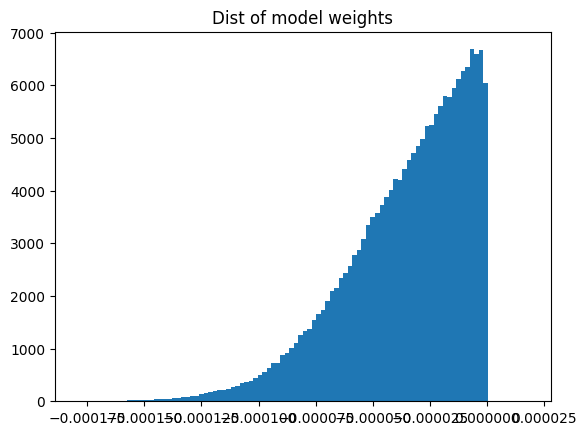

Outer epoch 1, Inner epoch 10, Loss: 	Avg Corr: 0.2576, Corr: 0.4768, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2779, Corr: 0.5135, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9284619092941284
Outer epoch 1, Inner epoch 20, Loss: 	Avg Corr: 0.2591, Corr: 0.4791, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2779, Corr: 0.5135, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9328756928443909
Outer epoch 1, Inner epoch 30, Loss: 	Avg Corr: 0.2597, Corr: 0.4800, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2779, Corr: 0.5135, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9346933364868164
Outer epoch 1, Inner epoch 40, Loss: 	Avg Corr: 0.2599, Corr: 0.4803, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2779, Corr: 0.5135, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9353614449501038
Outer epoch 1, Inner epoch 50, Loss: 	Avg Corr: 0.2600, Corr: 0.4805, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2779, Co

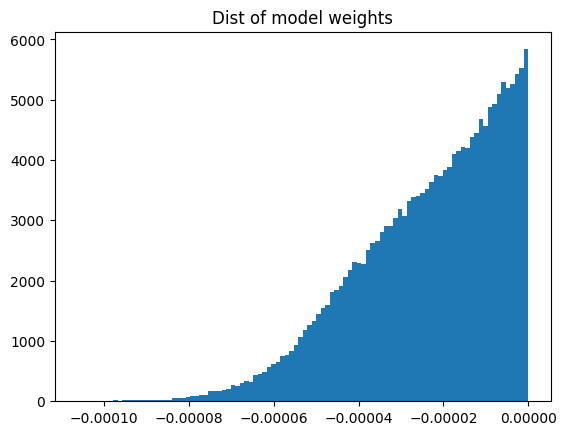

Outer epoch 2, Inner epoch 10, Loss: 	Avg Corr: 0.2280, Corr: 0.4005, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2359, Corr: 0.4243, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9438813328742981
Outer epoch 2, Inner epoch 20, Loss: 	Avg Corr: 0.2274, Corr: 0.3986, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2359, Corr: 0.4243, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9394859075546265
Outer epoch 2, Inner epoch 30, Loss: 	Avg Corr: 0.2274, Corr: 0.3979, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2359, Corr: 0.4243, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9378362894058228
Outer epoch 2, Inner epoch 40, Loss: 	Avg Corr: 0.2274, Corr: 0.3977, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2359, Corr: 0.4243, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9372471570968628
Outer epoch 2, Inner epoch 50, Loss: 	Avg Corr: 0.2274, Corr: 0.3976, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2359, Co

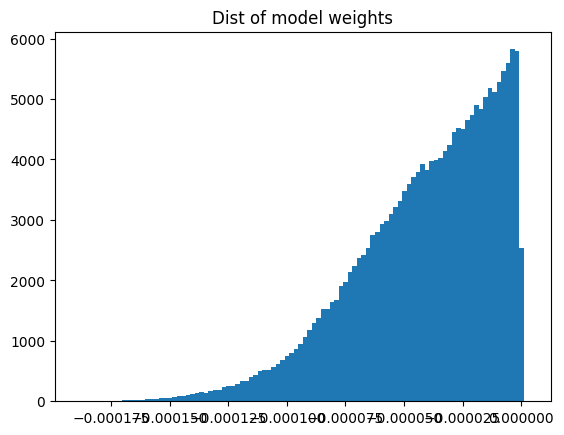

Outer epoch 3, Inner epoch 10, Loss: 	Avg Corr: 0.3019, Corr: 0.5852, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3233, Corr: 0.6429, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9102316498756409
Outer epoch 3, Inner epoch 20, Loss: 	Avg Corr: 0.3000, Corr: 0.5798, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3233, Corr: 0.6429, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9017059803009033
Outer epoch 3, Inner epoch 30, Loss: 	Avg Corr: 0.2994, Corr: 0.5781, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3233, Corr: 0.6429, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8991767764091492
Outer epoch 3, Inner epoch 40, Loss: 	Avg Corr: 0.2992, Corr: 0.5775, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3233, Corr: 0.6429, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8982728123664856
Outer epoch 3, Inner epoch 50, Loss: 	Avg Corr: 0.2991, Corr: 0.5773, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3233, Co

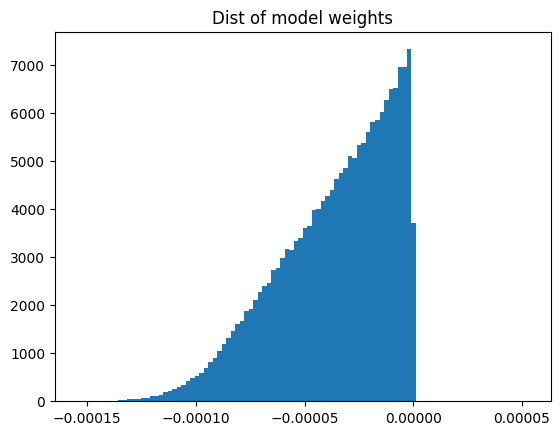

Outer epoch 4, Inner epoch 10, Loss: 	Avg Corr: 0.3347, Corr: 0.6833, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3896, Corr: 0.8790, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.7773498296737671
Outer epoch 4, Inner epoch 20, Loss: 	Avg Corr: 0.3323, Corr: 0.6773, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3896, Corr: 0.8790, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.7705596685409546
Outer epoch 4, Inner epoch 30, Loss: 	Avg Corr: 0.3315, Corr: 0.6753, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3896, Corr: 0.8790, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.7682206630706787
Outer epoch 4, Inner epoch 40, Loss: 	Avg Corr: 0.3312, Corr: 0.6745, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3896, Corr: 0.8790, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.7674033045768738
Outer epoch 4, Inner epoch 50, Loss: 	Avg Corr: 0.3311, Corr: 0.6743, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3896, Co

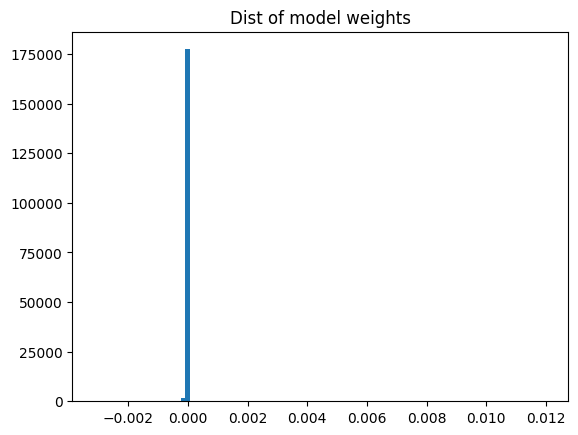

Outer epoch 5, Inner epoch 10, Loss: 	Avg Corr: 0.2616, Corr: 0.3901, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2602, Corr: 0.3994, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9765204787254333
Outer epoch 5, Inner epoch 20, Loss: 	Avg Corr: 0.2616, Corr: 0.3891, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2602, Corr: 0.3994, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9741800427436829
Outer epoch 5, Inner epoch 30, Loss: 	Avg Corr: 0.2615, Corr: 0.3888, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2602, Corr: 0.3994, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9733222126960754
Outer epoch 5, Inner epoch 40, Loss: 	Avg Corr: 0.2615, Corr: 0.3887, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2602, Corr: 0.3994, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9730207324028015
Outer epoch 5, Inner epoch 50, Loss: 	Avg Corr: 0.2615, Corr: 0.3886, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2602, Co

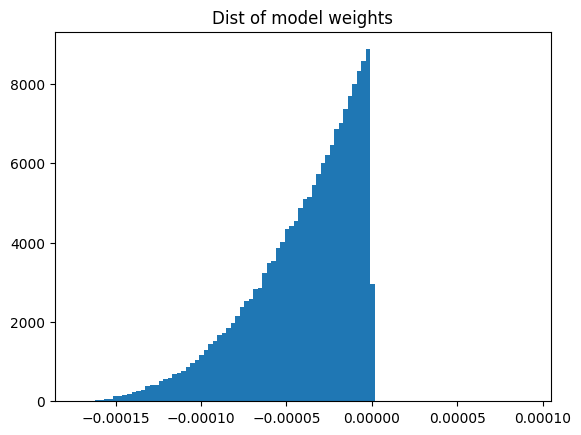

Outer epoch 6, Inner epoch 10, Loss: 	Avg Corr: 0.2611, Corr: 0.4340, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2642, Corr: 0.4634, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9365137219429016
Outer epoch 6, Inner epoch 20, Loss: 	Avg Corr: 0.2614, Corr: 0.4339, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2642, Corr: 0.4634, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9361494779586792
Outer epoch 6, Inner epoch 30, Loss: 	Avg Corr: 0.2614, Corr: 0.4337, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2642, Corr: 0.4634, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.935841977596283
Outer epoch 6, Inner epoch 40, Loss: 	Avg Corr: 0.2614, Corr: 0.4337, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2642, Corr: 0.4634, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9357656836509705
Outer epoch 6, Inner epoch 50, Loss: 	Avg Corr: 0.2614, Corr: 0.4336, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2642, Cor

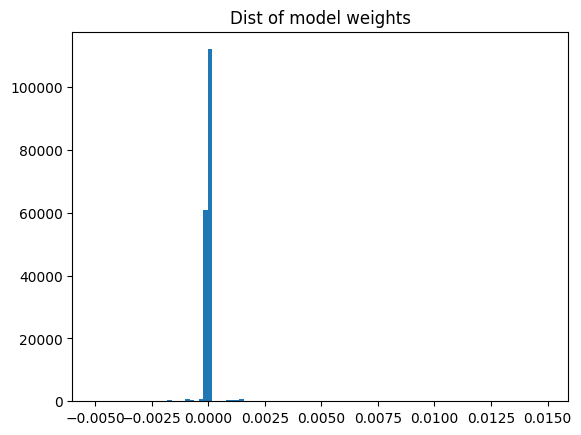

Outer epoch 7, Inner epoch 10, Loss: 	Avg Corr: 0.3599, Corr: 0.7482, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3899, Corr: 0.8483, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8820640444755554
Outer epoch 7, Inner epoch 20, Loss: 	Avg Corr: 0.3460, Corr: 0.7166, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3899, Corr: 0.8483, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8447469472885132
Outer epoch 7, Inner epoch 30, Loss: 	Avg Corr: 0.3467, Corr: 0.7180, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3899, Corr: 0.8483, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8464750647544861
Outer epoch 7, Inner epoch 40, Loss: 	Avg Corr: 0.3464, Corr: 0.7173, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3899, Corr: 0.8483, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8456624150276184
Outer epoch 7, Inner epoch 50, Loss: 	Avg Corr: 0.3462, Corr: 0.7166, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3899, Co

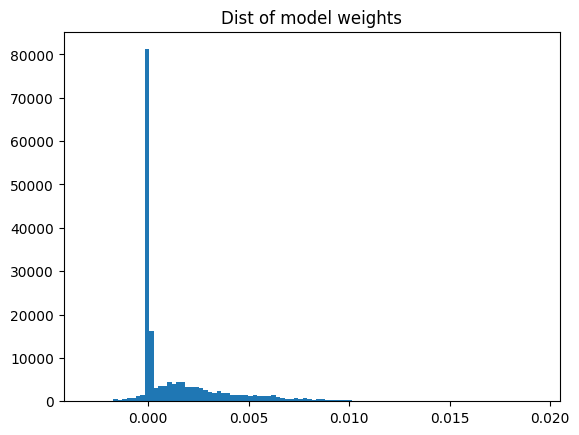

Outer epoch 8, Inner epoch 10, Loss: 	Avg Corr: 0.3160, Corr: 0.5578, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3094, Corr: 0.5580, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9996337294578552
Outer epoch 8, Inner epoch 20, Loss: 	Avg Corr: 0.3367, Corr: 0.6337, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3094, Corr: 0.5580, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1356096267700195
Outer epoch 8, Inner epoch 30, Loss: 	Avg Corr: 0.3366, Corr: 0.6333, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3094, Corr: 0.5580, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.134848713874817
Outer epoch 8, Inner epoch 40, Loss: 	Avg Corr: 0.3382, Corr: 0.6397, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3094, Corr: 0.5580, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1463581323623657
Outer epoch 8, Inner epoch 50, Loss: 	Avg Corr: 0.3387, Corr: 0.6409, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3094, Cor

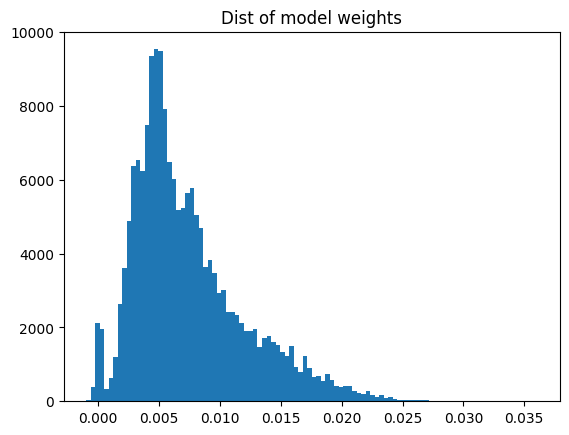

Outer epoch 9, Inner epoch 10, Loss: 	Avg Corr: 0.2515, Corr: 0.4434, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2638, Corr: 0.5009, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8851826786994934
Outer epoch 9, Inner epoch 20, Loss: 	Avg Corr: 0.2520, Corr: 0.4478, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2638, Corr: 0.5009, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8940374255180359
Outer epoch 9, Inner epoch 30, Loss: 	Avg Corr: 0.2541, Corr: 0.4601, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2638, Corr: 0.5009, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9185709357261658
Outer epoch 9, Inner epoch 40, Loss: 	Avg Corr: 0.2566, Corr: 0.4732, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2638, Corr: 0.5009, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9446157217025757
Outer epoch 9, Inner epoch 50, Loss: 	Avg Corr: 0.2586, Corr: 0.4828, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2638, Co

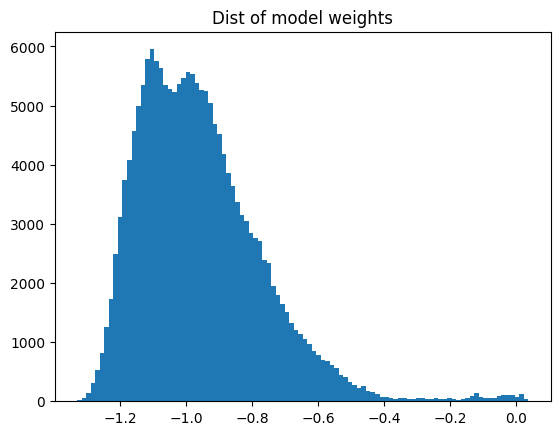

Outer epoch 10, Inner epoch 10, Loss: 	Avg Corr: 0.2601, Corr: 0.4384, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2901, Corr: 0.5205, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8423029780387878
Outer epoch 10, Inner epoch 20, Loss: 	Avg Corr: 0.2555, Corr: 0.4307, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2901, Corr: 0.5205, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8274752497673035
Outer epoch 10, Inner epoch 30, Loss: 	Avg Corr: 0.2552, Corr: 0.4330, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2901, Corr: 0.5205, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8318513035774231
Outer epoch 10, Inner epoch 40, Loss: 	Avg Corr: 0.2558, Corr: 0.4374, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2901, Corr: 0.5205, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8404800891876221
Outer epoch 10, Inner epoch 50, Loss: 	Avg Corr: 0.2560, Corr: 0.4410, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.290

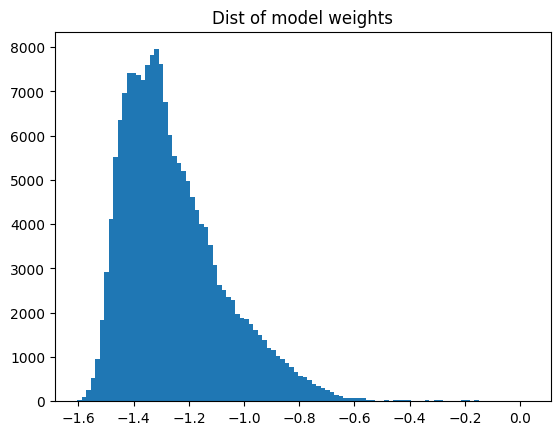

Outer epoch 11, Inner epoch 10, Loss: 	Avg Corr: 0.2846, Corr: 0.5315, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2935, Corr: 0.5065, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0492690801620483
Outer epoch 11, Inner epoch 20, Loss: 	Avg Corr: 0.2860, Corr: 0.5141, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2935, Corr: 0.5065, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0150867700576782
Outer epoch 11, Inner epoch 30, Loss: 	Avg Corr: 0.2867, Corr: 0.5137, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2935, Corr: 0.5065, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0141198635101318
Outer epoch 11, Inner epoch 40, Loss: 	Avg Corr: 0.2868, Corr: 0.5165, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2935, Corr: 0.5065, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0197930335998535
Outer epoch 11, Inner epoch 50, Loss: 	Avg Corr: 0.2868, Corr: 0.5212, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.293

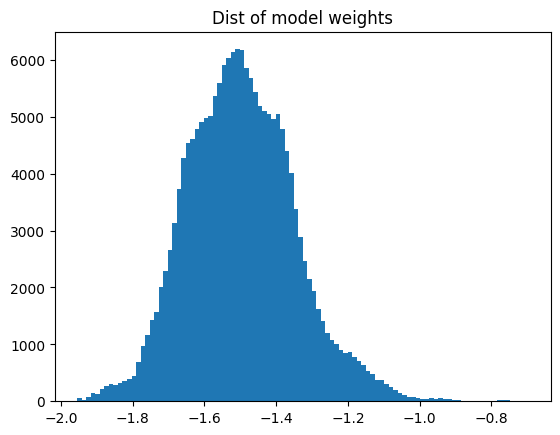

Outer epoch 12, Inner epoch 10, Loss: 	Avg Corr: 0.3090, Corr: 0.6005, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2918, Corr: 0.5399, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1122368574142456
Outer epoch 12, Inner epoch 20, Loss: 	Avg Corr: 0.3024, Corr: 0.6067, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2918, Corr: 0.5399, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1237374544143677
Outer epoch 12, Inner epoch 30, Loss: 	Avg Corr: 0.2989, Corr: 0.6014, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2918, Corr: 0.5399, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1139603853225708
Outer epoch 12, Inner epoch 40, Loss: 	Avg Corr: 0.2844, Corr: 0.5578, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2918, Corr: 0.5399, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.033130168914795
Outer epoch 12, Inner epoch 50, Loss: 	Avg Corr: 0.3039, Corr: 0.6397, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2918

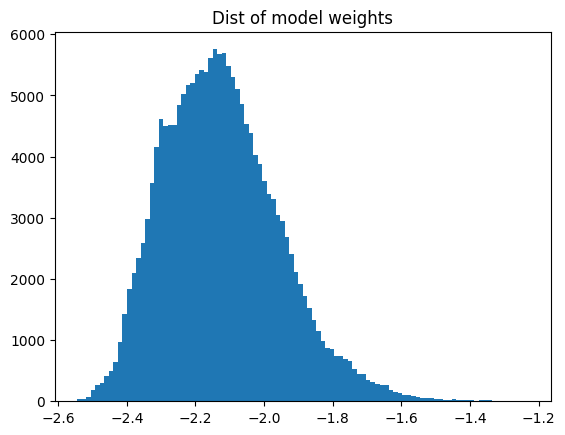

Outer epoch 13, Inner epoch 10, Loss: 	Avg Corr: 0.3116, Corr: 0.7015, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2837, Corr: 0.4825, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.4538174867630005
Outer epoch 13, Inner epoch 20, Loss: 	Avg Corr: 0.3108, Corr: 0.7068, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2837, Corr: 0.4825, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.4647142887115479
Outer epoch 13, Inner epoch 30, Loss: 	Avg Corr: 0.3115, Corr: 0.7096, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2837, Corr: 0.4825, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.4705860614776611
Outer epoch 13, Inner epoch 40, Loss: 	Avg Corr: 0.3119, Corr: 0.7105, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2837, Corr: 0.4825, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.4724284410476685
Outer epoch 13, Inner epoch 50, Loss: 	Avg Corr: 0.3127, Corr: 0.7126, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.283

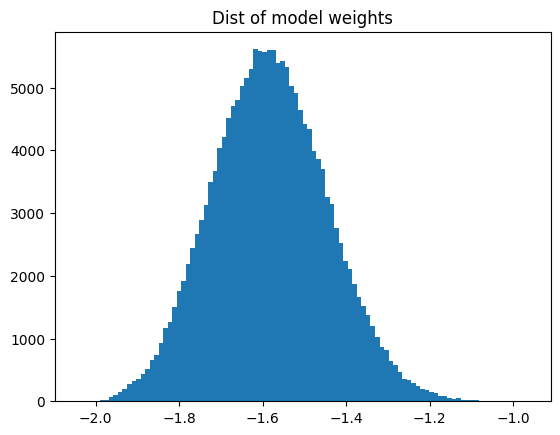

Outer epoch 14, Inner epoch 10, Loss: 	Avg Corr: 0.3692, Corr: 0.8185, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3160, Corr: 0.6374, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.2841429710388184
Outer epoch 14, Inner epoch 20, Loss: 	Avg Corr: 0.3900, Corr: 0.9296, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3160, Corr: 0.6374, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.4583102464675903
Outer epoch 14, Inner epoch 30, Loss: 	Avg Corr: 0.3983, Corr: 0.9788, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3160, Corr: 0.6374, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.5354982614517212
Outer epoch 14, Inner epoch 40, Loss: 	Avg Corr: 0.4005, Corr: 0.9944, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3160, Corr: 0.6374, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.5600428581237793
Outer epoch 14, Inner epoch 50, Loss: 	Avg Corr: 0.4008, Corr: 0.9983, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.316

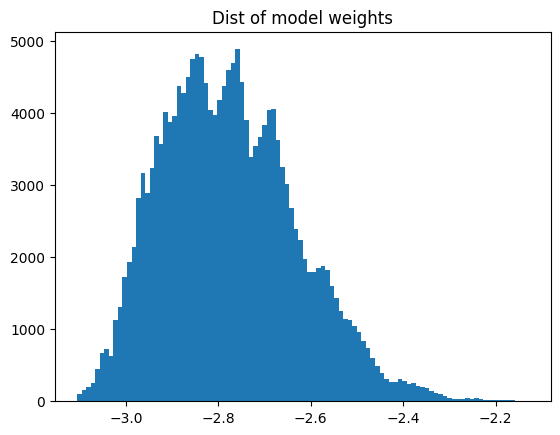

Outer epoch 15, Inner epoch 10, Loss: 	Avg Corr: 0.2892, Corr: 0.5945, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2634, Corr: 0.4438, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.339595913887024
Outer epoch 15, Inner epoch 20, Loss: 	Avg Corr: 0.2890, Corr: 0.6073, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2634, Corr: 0.4438, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.3685111999511719
Outer epoch 15, Inner epoch 30, Loss: 	Avg Corr: 0.2888, Corr: 0.6070, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2634, Corr: 0.4438, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.3677339553833008
Outer epoch 15, Inner epoch 40, Loss: 	Avg Corr: 0.2892, Corr: 0.6052, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2634, Corr: 0.4438, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.363774299621582
Outer epoch 15, Inner epoch 50, Loss: 	Avg Corr: 0.2896, Corr: 0.6032, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2634,

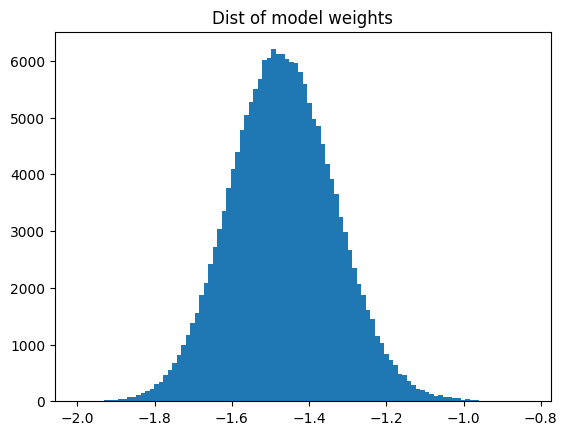

Outer epoch 16, Inner epoch 10, Loss: 	Avg Corr: 0.3018, Corr: 0.5432, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2857, Corr: 0.4984, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0899673700332642
Outer epoch 16, Inner epoch 20, Loss: 	Avg Corr: 0.3141, Corr: 0.6023, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2857, Corr: 0.4984, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.2084755897521973
Outer epoch 16, Inner epoch 30, Loss: 	Avg Corr: 0.2824, Corr: 0.5204, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2857, Corr: 0.4984, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0442043542861938
Outer epoch 16, Inner epoch 40, Loss: 	Avg Corr: 0.2791, Corr: 0.5274, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2857, Corr: 0.4984, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0582423210144043
Outer epoch 16, Inner epoch 50, Loss: 	Avg Corr: 0.2853, Corr: 0.5238, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.285

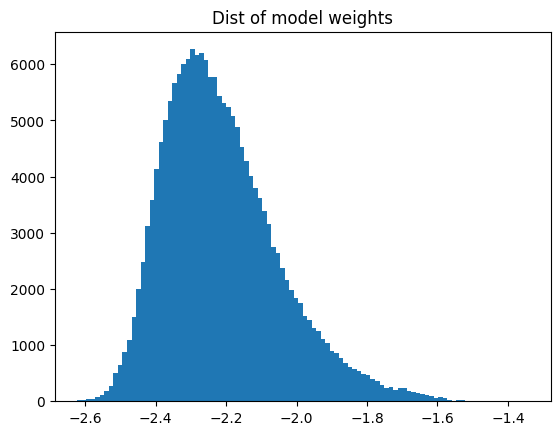

Outer epoch 17, Inner epoch 10, Loss: 	Avg Corr: 0.2968, Corr: 0.5569, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2822, Corr: 0.5013, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1108930110931396
Outer epoch 17, Inner epoch 20, Loss: 	Avg Corr: 0.2915, Corr: 0.5410, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2822, Corr: 0.5013, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0793232917785645
Outer epoch 17, Inner epoch 30, Loss: 	Avg Corr: 0.2891, Corr: 0.5332, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2822, Corr: 0.5013, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0637950897216797
Outer epoch 17, Inner epoch 40, Loss: 	Avg Corr: 0.2876, Corr: 0.5287, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2822, Corr: 0.5013, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.054672122001648
Outer epoch 17, Inner epoch 50, Loss: 	Avg Corr: 0.2866, Corr: 0.5254, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2822

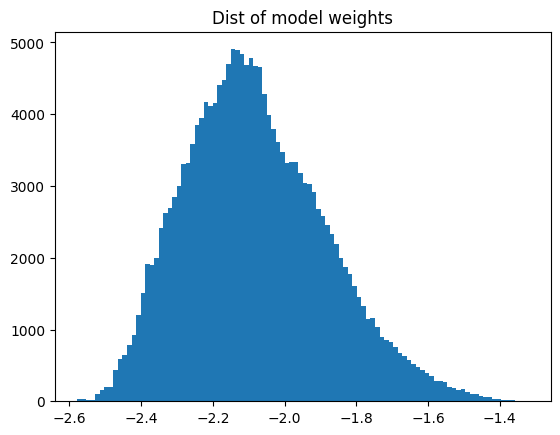

Outer epoch 18, Inner epoch 10, Loss: 	Avg Corr: 0.3105, Corr: 0.5643, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3173, Corr: 0.6080, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9280895590782166
Outer epoch 18, Inner epoch 20, Loss: 	Avg Corr: 0.3115, Corr: 0.5629, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3173, Corr: 0.6080, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9259394407272339
Outer epoch 18, Inner epoch 30, Loss: 	Avg Corr: 0.3117, Corr: 0.5623, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3173, Corr: 0.6080, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9249405264854431
Outer epoch 18, Inner epoch 40, Loss: 	Avg Corr: 0.3115, Corr: 0.5615, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3173, Corr: 0.6080, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9236198663711548
Outer epoch 18, Inner epoch 50, Loss: 	Avg Corr: 0.3113, Corr: 0.5611, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.317

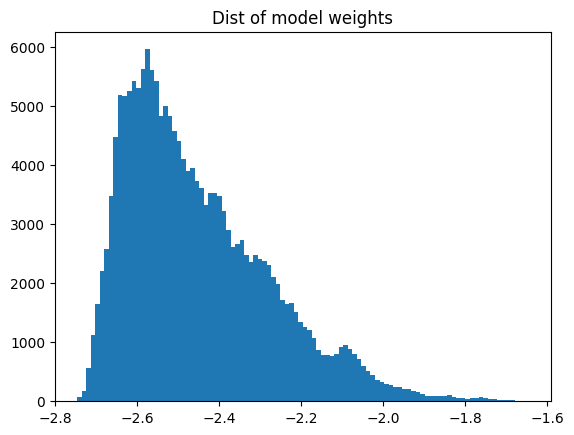

Outer epoch 19, Inner epoch 10, Loss: 	Avg Corr: 0.3240, Corr: 0.6263, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3231, Corr: 0.6194, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0111578702926636
Outer epoch 19, Inner epoch 20, Loss: 	Avg Corr: 0.3244, Corr: 0.6286, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3231, Corr: 0.6194, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0147713422775269
Outer epoch 19, Inner epoch 30, Loss: 	Avg Corr: 0.3242, Corr: 0.6288, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3231, Corr: 0.6194, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.015195608139038
Outer epoch 19, Inner epoch 40, Loss: 	Avg Corr: 0.3242, Corr: 0.6290, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3231, Corr: 0.6194, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0155030488967896
Outer epoch 19, Inner epoch 50, Loss: 	Avg Corr: 0.3243, Corr: 0.6292, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3231

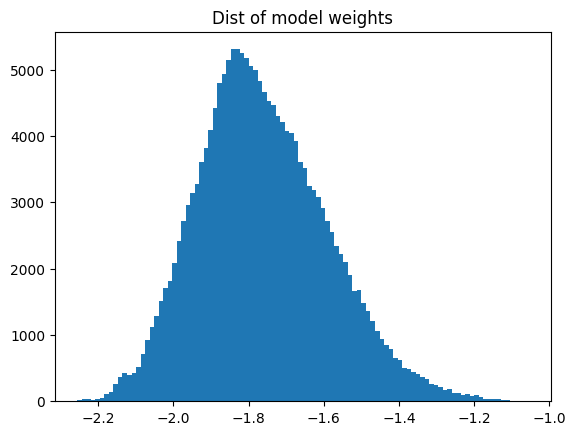

Outer epoch 20, Inner epoch 10, Loss: 	Avg Corr: 0.2831, Corr: 0.5563, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2655, Corr: 0.4555, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.2213993072509766
Outer epoch 20, Inner epoch 20, Loss: 	Avg Corr: 0.2948, Corr: 0.5948, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2655, Corr: 0.4555, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.305927038192749
Outer epoch 20, Inner epoch 30, Loss: 	Avg Corr: 0.2967, Corr: 0.6017, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2655, Corr: 0.4555, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.3209172487258911
Outer epoch 20, Inner epoch 40, Loss: 	Avg Corr: 0.2967, Corr: 0.6015, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2655, Corr: 0.4555, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.3205426931381226
Outer epoch 20, Inner epoch 50, Loss: 	Avg Corr: 0.2962, Corr: 0.5994, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2655

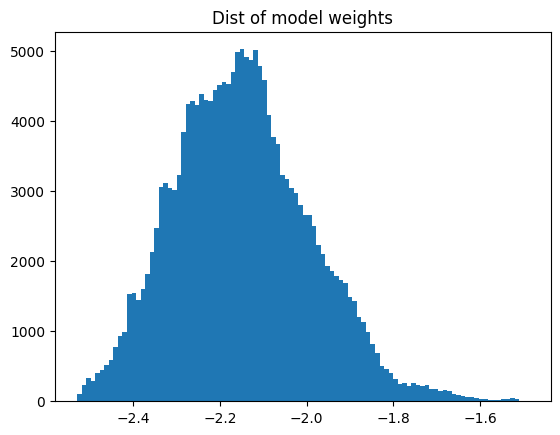

Outer epoch 21, Inner epoch 10, Loss: 	Avg Corr: 0.2546, Corr: 0.4085, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2884, Corr: 0.4833, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8452531099319458
Outer epoch 21, Inner epoch 20, Loss: 	Avg Corr: 0.2543, Corr: 0.4218, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2884, Corr: 0.4833, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8727357983589172
Outer epoch 21, Inner epoch 30, Loss: 	Avg Corr: 0.2566, Corr: 0.4281, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2884, Corr: 0.4833, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8858318328857422
Outer epoch 21, Inner epoch 40, Loss: 	Avg Corr: 0.2571, Corr: 0.4295, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2884, Corr: 0.4833, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8885515332221985
Outer epoch 21, Inner epoch 50, Loss: 	Avg Corr: 0.2571, Corr: 0.4295, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.288

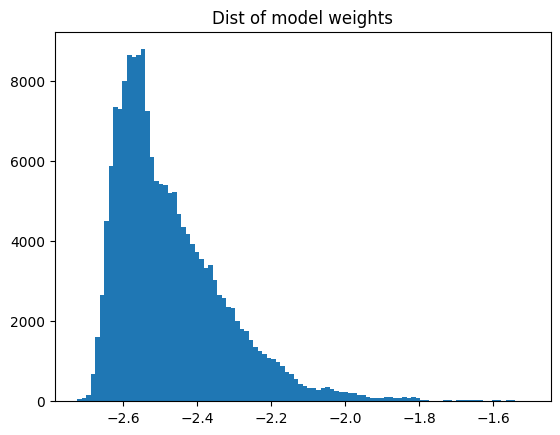

Outer epoch 22, Inner epoch 10, Loss: 	Avg Corr: 0.3580, Corr: 0.8740, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2952, Corr: 0.6370, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.3719923496246338
Outer epoch 22, Inner epoch 20, Loss: 	Avg Corr: 0.3675, Corr: 0.9174, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2952, Corr: 0.6370, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.4400502443313599
Outer epoch 22, Inner epoch 30, Loss: 	Avg Corr: 0.3695, Corr: 0.9259, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2952, Corr: 0.6370, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.4534975290298462
Outer epoch 22, Inner epoch 40, Loss: 	Avg Corr: 0.3698, Corr: 0.9272, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2952, Corr: 0.6370, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.4555717706680298
Outer epoch 22, Inner epoch 50, Loss: 	Avg Corr: 0.3697, Corr: 0.9268, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.295

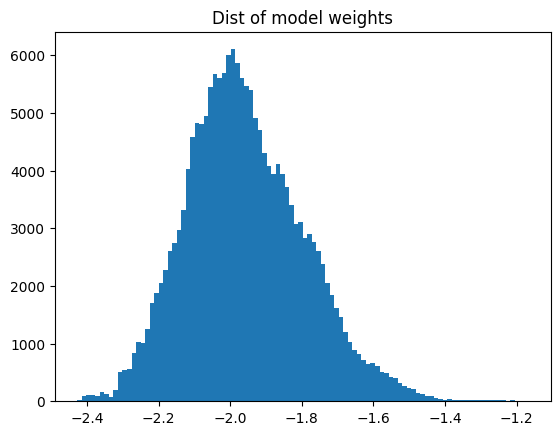

Outer epoch 23, Inner epoch 10, Loss: 	Avg Corr: 0.3558, Corr: 0.7035, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3372, Corr: 0.6456, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.08970308303833
Outer epoch 23, Inner epoch 20, Loss: 	Avg Corr: 0.3556, Corr: 0.7062, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3372, Corr: 0.6456, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0938482284545898
Outer epoch 23, Inner epoch 30, Loss: 	Avg Corr: 0.3550, Corr: 0.7045, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3372, Corr: 0.6456, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.091174602508545
Outer epoch 23, Inner epoch 40, Loss: 	Avg Corr: 0.3544, Corr: 0.7024, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3372, Corr: 0.6456, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.088025689125061
Outer epoch 23, Inner epoch 50, Loss: 	Avg Corr: 0.3538, Corr: 0.7004, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3372, C

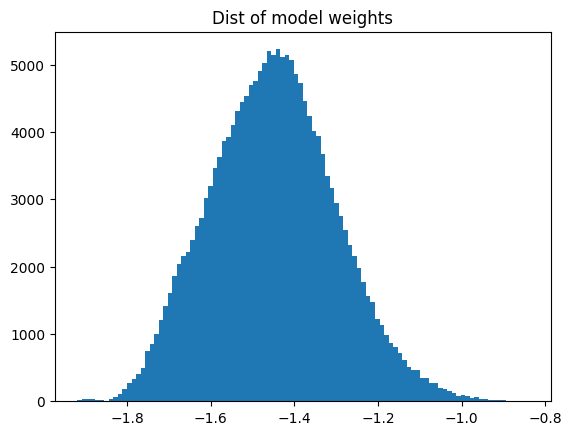

Outer epoch 24, Inner epoch 10, Loss: 	Avg Corr: 0.2875, Corr: 0.6263, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2553, Corr: 0.4139, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.5131086111068726
Outer epoch 24, Inner epoch 20, Loss: 	Avg Corr: 0.3025, Corr: 0.7411, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2553, Corr: 0.4139, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.7905189990997314
Outer epoch 24, Inner epoch 30, Loss: 	Avg Corr: 0.3024, Corr: 0.7476, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2553, Corr: 0.4139, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.8060816526412964
Outer epoch 24, Inner epoch 40, Loss: 	Avg Corr: 0.3007, Corr: 0.7395, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2553, Corr: 0.4139, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.7867200374603271
Outer epoch 24, Inner epoch 50, Loss: 	Avg Corr: 0.2986, Corr: 0.7272, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.255

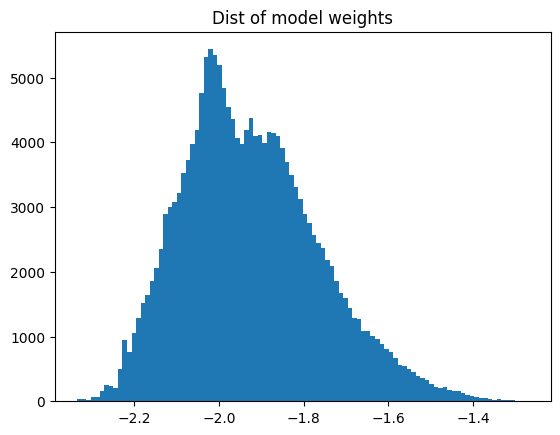

Outer epoch 25, Inner epoch 10, Loss: 	Avg Corr: 0.2912, Corr: 0.5768, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3147, Corr: 0.6218, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9275100827217102
Outer epoch 25, Inner epoch 20, Loss: 	Avg Corr: 0.3037, Corr: 0.6188, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3147, Corr: 0.6218, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.995152473449707
Outer epoch 25, Inner epoch 30, Loss: 	Avg Corr: 0.3044, Corr: 0.6241, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3147, Corr: 0.6218, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0036643743515015
Outer epoch 25, Inner epoch 40, Loss: 	Avg Corr: 0.3032, Corr: 0.6213, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3147, Corr: 0.6218, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9990505576133728
Outer epoch 25, Inner epoch 50, Loss: 	Avg Corr: 0.3018, Corr: 0.6172, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3147

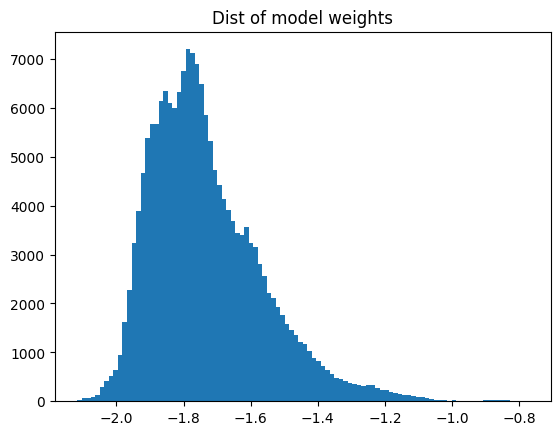

Outer epoch 26, Inner epoch 10, Loss: 	Avg Corr: 0.3043, Corr: 0.5756, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3202, Corr: 0.6185, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9305710196495056
Outer epoch 26, Inner epoch 20, Loss: 	Avg Corr: 0.3002, Corr: 0.5785, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3202, Corr: 0.6185, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9352809190750122
Outer epoch 26, Inner epoch 30, Loss: 	Avg Corr: 0.2997, Corr: 0.5781, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3202, Corr: 0.6185, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9346767067909241
Outer epoch 26, Inner epoch 40, Loss: 	Avg Corr: 0.2997, Corr: 0.5781, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3202, Corr: 0.6185, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.934657633304596
Outer epoch 26, Inner epoch 50, Loss: 	Avg Corr: 0.2997, Corr: 0.5784, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3202

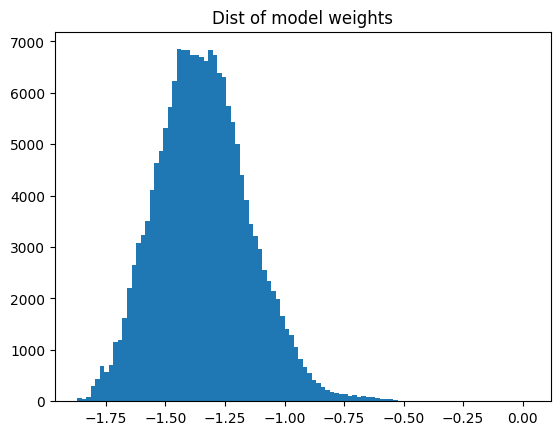

Outer epoch 27, Inner epoch 10, Loss: 	Avg Corr: 0.2931, Corr: 0.5880, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3172, Corr: 0.6138, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9580128192901611
Outer epoch 27, Inner epoch 20, Loss: 	Avg Corr: 0.2937, Corr: 0.5827, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3172, Corr: 0.6138, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9493731260299683
Outer epoch 27, Inner epoch 30, Loss: 	Avg Corr: 0.2937, Corr: 0.5829, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3172, Corr: 0.6138, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9496533870697021
Outer epoch 27, Inner epoch 40, Loss: 	Avg Corr: 0.2940, Corr: 0.5839, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3172, Corr: 0.6138, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9512551426887512
Outer epoch 27, Inner epoch 50, Loss: 	Avg Corr: 0.2942, Corr: 0.5849, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.317

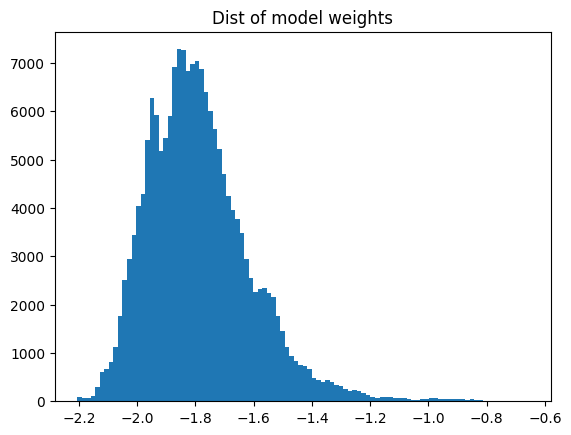

Outer epoch 28, Inner epoch 10, Loss: 	Avg Corr: 0.2425, Corr: 0.4102, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2433, Corr: 0.3840, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0682624578475952
Outer epoch 28, Inner epoch 20, Loss: 	Avg Corr: 0.2422, Corr: 0.4123, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2433, Corr: 0.3840, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0736366510391235
Outer epoch 28, Inner epoch 30, Loss: 	Avg Corr: 0.2423, Corr: 0.4128, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2433, Corr: 0.3840, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0749152898788452
Outer epoch 28, Inner epoch 40, Loss: 	Avg Corr: 0.2422, Corr: 0.4127, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2433, Corr: 0.3840, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.074649691581726
Outer epoch 28, Inner epoch 50, Loss: 	Avg Corr: 0.2419, Corr: 0.4124, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2433

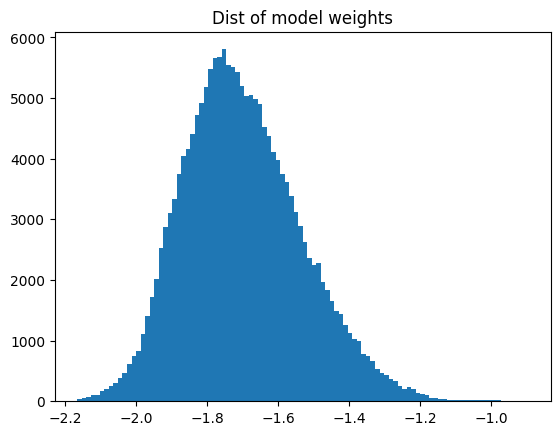

Outer epoch 29, Inner epoch 10, Loss: 	Avg Corr: 0.3697, Corr: 0.8513, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2678, Corr: 0.4505, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.8897016048431396
Outer epoch 29, Inner epoch 20, Loss: 	Avg Corr: 0.3877, Corr: 0.9155, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2678, Corr: 0.4505, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 2.03206205368042
Outer epoch 29, Inner epoch 30, Loss: 	Avg Corr: 0.3912, Corr: 0.9262, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2678, Corr: 0.4505, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 2.055832624435425
Outer epoch 29, Inner epoch 40, Loss: 	Avg Corr: 0.3910, Corr: 0.9255, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2678, Corr: 0.4505, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 2.0542595386505127
Outer epoch 29, Inner epoch 50, Loss: 	Avg Corr: 0.3886, Corr: 0.9178, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2678, 

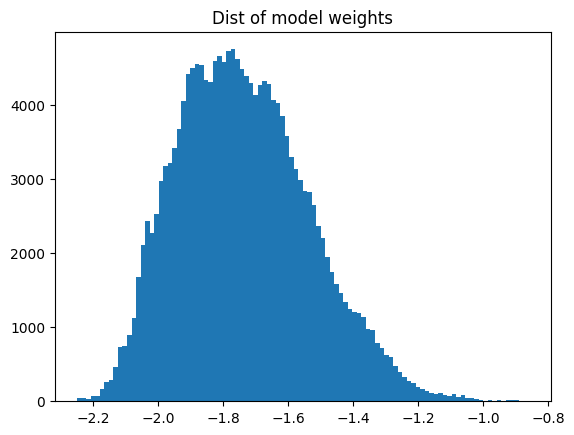

Outer epoch 30, Inner epoch 10, Loss: 	Avg Corr: 0.2846, Corr: 0.6129, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2671, Corr: 0.4520, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.3559980392456055
Outer epoch 30, Inner epoch 20, Loss: 	Avg Corr: 0.2914, Corr: 0.6266, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2671, Corr: 0.4520, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.3863211870193481
Outer epoch 30, Inner epoch 30, Loss: 	Avg Corr: 0.2923, Corr: 0.6260, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2671, Corr: 0.4520, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.3848375082015991
Outer epoch 30, Inner epoch 40, Loss: 	Avg Corr: 0.2922, Corr: 0.6245, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2671, Corr: 0.4520, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.3815845251083374
Outer epoch 30, Inner epoch 50, Loss: 	Avg Corr: 0.2918, Corr: 0.6232, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.267

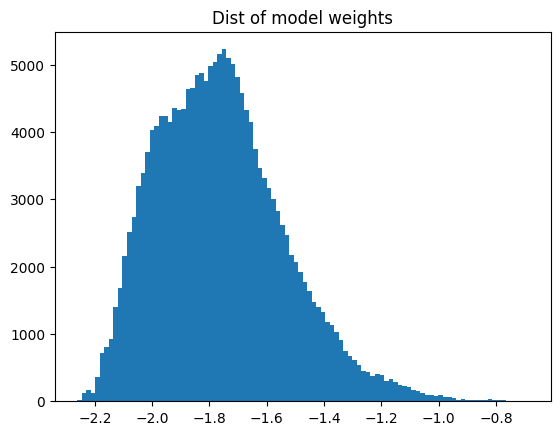

Outer epoch 31, Inner epoch 10, Loss: 	Avg Corr: 0.4201, Corr: 1.0716, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3545, Corr: 0.7148, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.4991177320480347
Outer epoch 31, Inner epoch 20, Loss: 	Avg Corr: 0.4196, Corr: 1.0884, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3545, Corr: 0.7148, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.522597074508667
Outer epoch 31, Inner epoch 30, Loss: 	Avg Corr: 0.4141, Corr: 1.0699, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3545, Corr: 0.7148, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.4967283010482788
Outer epoch 31, Inner epoch 40, Loss: 	Avg Corr: 0.4070, Corr: 1.0433, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3545, Corr: 0.7148, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.4595705270767212
Outer epoch 31, Inner epoch 50, Loss: 	Avg Corr: 0.3985, Corr: 1.0100, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3545

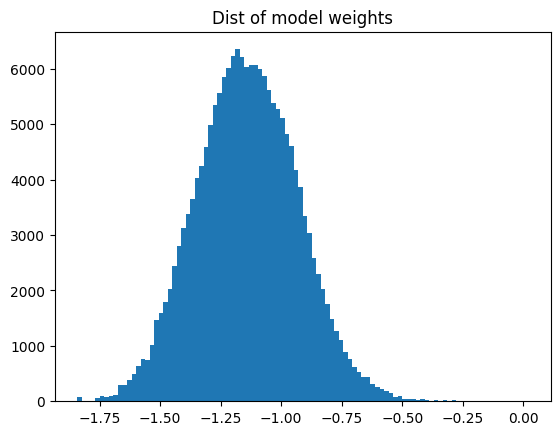

Outer epoch 32, Inner epoch 10, Loss: 	Avg Corr: 0.2923, Corr: 0.5772, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2683, Corr: 0.5362, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.076355218887329
Outer epoch 32, Inner epoch 20, Loss: 	Avg Corr: 0.2888, Corr: 0.5685, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2683, Corr: 0.5362, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.060163140296936
Outer epoch 32, Inner epoch 30, Loss: 	Avg Corr: 0.2837, Corr: 0.5502, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2683, Corr: 0.5362, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0260416269302368
Outer epoch 32, Inner epoch 40, Loss: 	Avg Corr: 0.2795, Corr: 0.5323, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2683, Corr: 0.5362, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9926720261573792
Outer epoch 32, Inner epoch 50, Loss: 	Avg Corr: 0.2752, Corr: 0.5141, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2683,

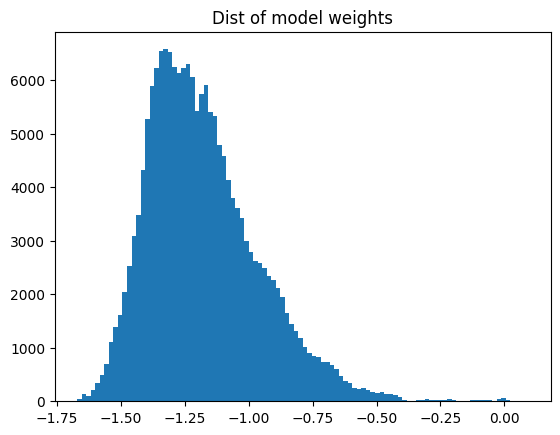

Outer epoch 33, Inner epoch 10, Loss: 	Avg Corr: 0.2907, Corr: 0.5185, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2854, Corr: 0.4738, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0944308042526245
Outer epoch 33, Inner epoch 20, Loss: 	Avg Corr: 0.2903, Corr: 0.5272, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2854, Corr: 0.4738, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1127315759658813
Outer epoch 33, Inner epoch 30, Loss: 	Avg Corr: 0.2802, Corr: 0.4913, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2854, Corr: 0.4738, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0370166301727295
Outer epoch 33, Inner epoch 40, Loss: 	Avg Corr: 0.2691, Corr: 0.4535, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2854, Corr: 0.4738, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9571974873542786
Outer epoch 33, Inner epoch 50, Loss: 	Avg Corr: 0.2614, Corr: 0.4226, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.285

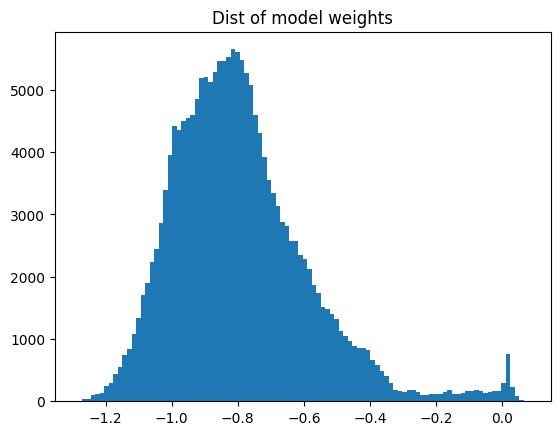

Outer epoch 34, Inner epoch 10, Loss: 	Avg Corr: 0.3257, Corr: 0.6552, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3550, Corr: 0.7432, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8815886974334717
Outer epoch 34, Inner epoch 20, Loss: 	Avg Corr: 0.3221, Corr: 0.6425, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3550, Corr: 0.7432, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8644810318946838
Outer epoch 34, Inner epoch 30, Loss: 	Avg Corr: 0.3165, Corr: 0.6248, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3550, Corr: 0.7432, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8406556248664856
Outer epoch 34, Inner epoch 40, Loss: 	Avg Corr: 0.3171, Corr: 0.6255, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3550, Corr: 0.7432, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8415878415107727
Outer epoch 34, Inner epoch 50, Loss: 	Avg Corr: 0.3180, Corr: 0.6276, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.355

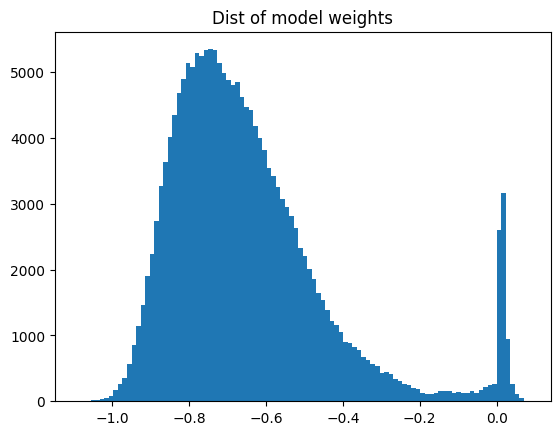

Outer epoch 35, Inner epoch 10, Loss: 	Avg Corr: 0.2888, Corr: 0.5239, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3155, Corr: 0.6331, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8274478912353516
Outer epoch 35, Inner epoch 20, Loss: 	Avg Corr: 0.2837, Corr: 0.5155, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3155, Corr: 0.6331, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8141534328460693
Outer epoch 35, Inner epoch 30, Loss: 	Avg Corr: 0.2842, Corr: 0.5176, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3155, Corr: 0.6331, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8175150156021118
Outer epoch 35, Inner epoch 40, Loss: 	Avg Corr: 0.2847, Corr: 0.5199, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3155, Corr: 0.6331, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8212189674377441
Outer epoch 35, Inner epoch 50, Loss: 	Avg Corr: 0.2847, Corr: 0.5216, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.315

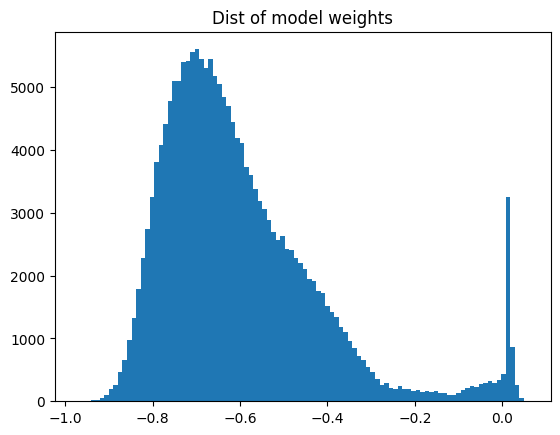

Outer epoch 36, Inner epoch 10, Loss: 	Avg Corr: 0.2574, Corr: 0.3755, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2680, Corr: 0.4444, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.844845175743103
Outer epoch 36, Inner epoch 20, Loss: 	Avg Corr: 0.2572, Corr: 0.3691, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2680, Corr: 0.4444, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8305709958076477
Outer epoch 36, Inner epoch 30, Loss: 	Avg Corr: 0.2564, Corr: 0.3682, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2680, Corr: 0.4444, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.828440248966217
Outer epoch 36, Inner epoch 40, Loss: 	Avg Corr: 0.2565, Corr: 0.3732, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2680, Corr: 0.4444, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8397539258003235
Outer epoch 36, Inner epoch 50, Loss: 	Avg Corr: 0.2549, Corr: 0.3767, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2680,

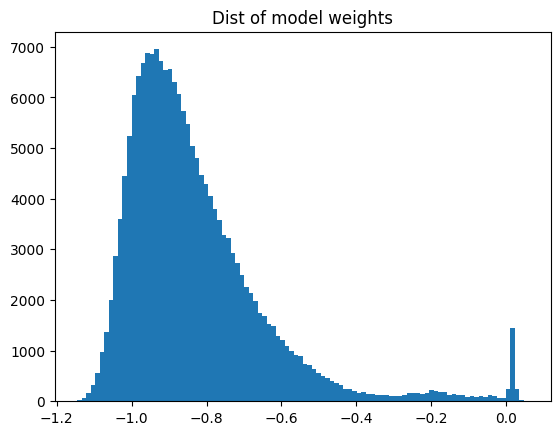

Outer epoch 37, Inner epoch 10, Loss: 	Avg Corr: 0.2791, Corr: 0.4778, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3068, Corr: 0.5659, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8442828059196472
Outer epoch 37, Inner epoch 20, Loss: 	Avg Corr: 0.2728, Corr: 0.4650, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3068, Corr: 0.5659, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8216748833656311
Outer epoch 37, Inner epoch 30, Loss: 	Avg Corr: 0.2720, Corr: 0.4670, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3068, Corr: 0.5659, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8251620531082153
Outer epoch 37, Inner epoch 40, Loss: 	Avg Corr: 0.2721, Corr: 0.4705, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3068, Corr: 0.5659, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8314408659934998
Outer epoch 37, Inner epoch 50, Loss: 	Avg Corr: 0.2737, Corr: 0.4768, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.306

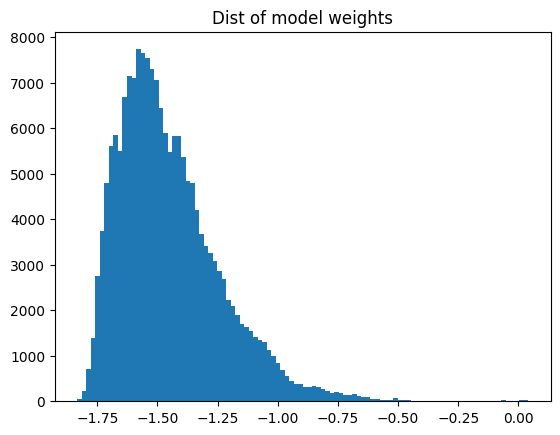

Outer epoch 38, Inner epoch 10, Loss: 	Avg Corr: 0.3322, Corr: 0.6688, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3181, Corr: 0.6275, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.065687656402588
Outer epoch 38, Inner epoch 20, Loss: 	Avg Corr: 0.3488, Corr: 0.7520, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3181, Corr: 0.6275, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1982723474502563
Outer epoch 38, Inner epoch 30, Loss: 	Avg Corr: 0.3551, Corr: 0.7884, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3181, Corr: 0.6275, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.2563629150390625
Outer epoch 38, Inner epoch 40, Loss: 	Avg Corr: 0.3583, Corr: 0.8075, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3181, Corr: 0.6275, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.2867871522903442
Outer epoch 38, Inner epoch 50, Loss: 	Avg Corr: 0.3594, Corr: 0.8142, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3181

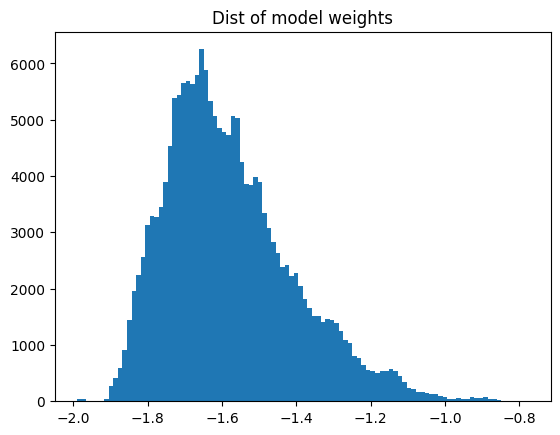

Outer epoch 39, Inner epoch 10, Loss: 	Avg Corr: 0.2145, Corr: 0.3109, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2511, Corr: 0.3745, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8301410675048828
Outer epoch 39, Inner epoch 20, Loss: 	Avg Corr: 0.2162, Corr: 0.3298, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2511, Corr: 0.3745, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8806121945381165
Outer epoch 39, Inner epoch 30, Loss: 	Avg Corr: 0.2158, Corr: 0.3337, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2511, Corr: 0.3745, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8910836577415466
Outer epoch 39, Inner epoch 40, Loss: 	Avg Corr: 0.2150, Corr: 0.3323, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2511, Corr: 0.3745, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8872843980789185
Outer epoch 39, Inner epoch 50, Loss: 	Avg Corr: 0.2139, Corr: 0.3293, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.251

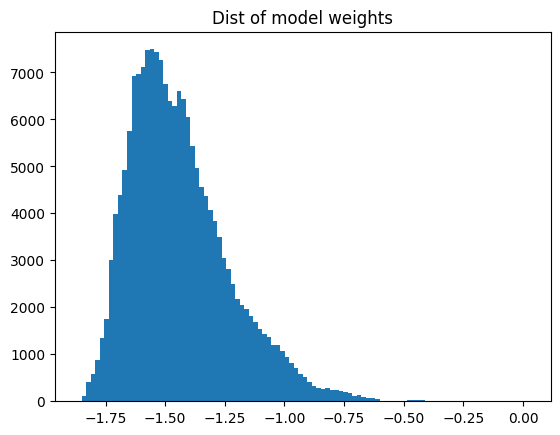

Outer epoch 40, Inner epoch 10, Loss: 	Avg Corr: 0.2567, Corr: 0.4313, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2767, Corr: 0.4637, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9300879240036011
Outer epoch 40, Inner epoch 20, Loss: 	Avg Corr: 0.2553, Corr: 0.4431, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2767, Corr: 0.4637, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9556215405464172
Outer epoch 40, Inner epoch 30, Loss: 	Avg Corr: 0.2553, Corr: 0.4490, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2767, Corr: 0.4637, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9681821465492249
Outer epoch 40, Inner epoch 40, Loss: 	Avg Corr: 0.2552, Corr: 0.4520, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2767, Corr: 0.4637, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9746734499931335
Outer epoch 40, Inner epoch 50, Loss: 	Avg Corr: 0.2551, Corr: 0.4558, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.276

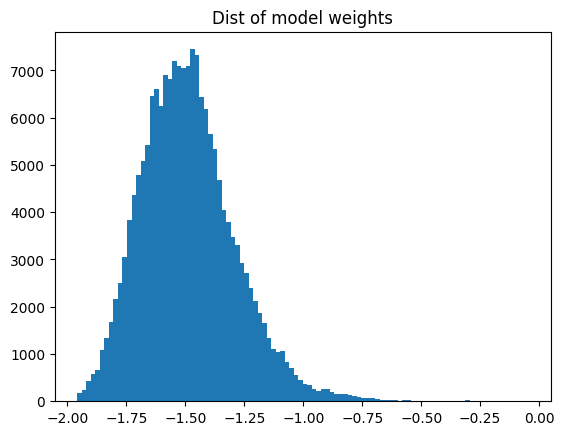

Outer epoch 41, Inner epoch 10, Loss: 	Avg Corr: 0.2325, Corr: 0.4025, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2373, Corr: 0.3489, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1535452604293823
Outer epoch 41, Inner epoch 20, Loss: 	Avg Corr: 0.2363, Corr: 0.4094, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2373, Corr: 0.3489, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1734507083892822
Outer epoch 41, Inner epoch 30, Loss: 	Avg Corr: 0.2372, Corr: 0.4110, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2373, Corr: 0.3489, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1780602931976318
Outer epoch 41, Inner epoch 40, Loss: 	Avg Corr: 0.2378, Corr: 0.4122, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2373, Corr: 0.3489, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1814815998077393
Outer epoch 41, Inner epoch 50, Loss: 	Avg Corr: 0.2381, Corr: 0.4128, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.237

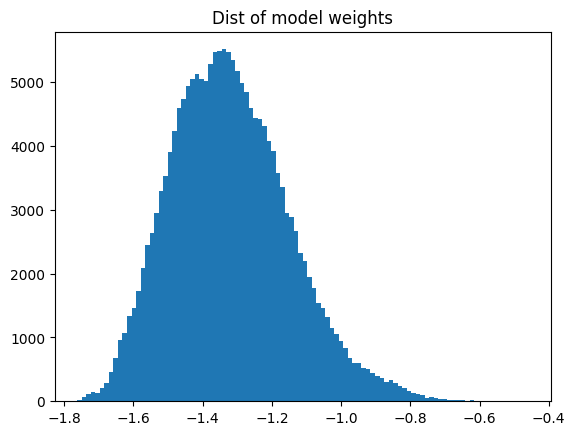

Outer epoch 42, Inner epoch 10, Loss: 	Avg Corr: 0.3372, Corr: 0.7118, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3371, Corr: 0.7064, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.007726788520813
Outer epoch 42, Inner epoch 20, Loss: 	Avg Corr: 0.3251, Corr: 0.6691, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3371, Corr: 0.7064, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9472172856330872
Outer epoch 42, Inner epoch 30, Loss: 	Avg Corr: 0.3209, Corr: 0.6556, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3371, Corr: 0.7064, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.928151547908783
Outer epoch 42, Inner epoch 40, Loss: 	Avg Corr: 0.3196, Corr: 0.6514, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3371, Corr: 0.7064, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9222363829612732
Outer epoch 42, Inner epoch 50, Loss: 	Avg Corr: 0.3190, Corr: 0.6493, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3371,

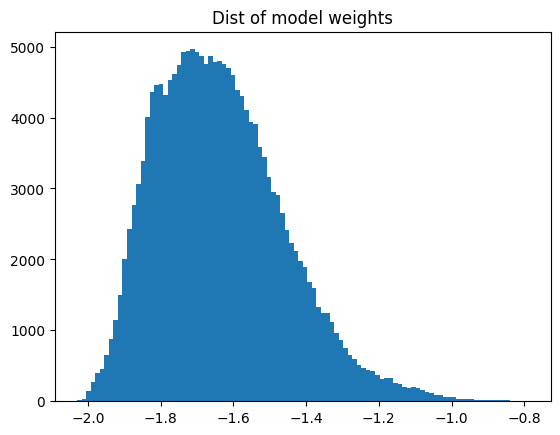

Outer epoch 43, Inner epoch 10, Loss: 	Avg Corr: 0.3377, Corr: 0.7315, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2535, Corr: 0.5068, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.4432299137115479
Outer epoch 43, Inner epoch 20, Loss: 	Avg Corr: 0.3711, Corr: 0.8961, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2535, Corr: 0.5068, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.7679097652435303
Outer epoch 43, Inner epoch 30, Loss: 	Avg Corr: 0.3739, Corr: 0.9202, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2535, Corr: 0.5068, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.8154419660568237
Outer epoch 43, Inner epoch 40, Loss: 	Avg Corr: 0.3691, Corr: 0.9041, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2535, Corr: 0.5068, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.783847451210022
Outer epoch 43, Inner epoch 50, Loss: 	Avg Corr: 0.3605, Corr: 0.8695, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2535

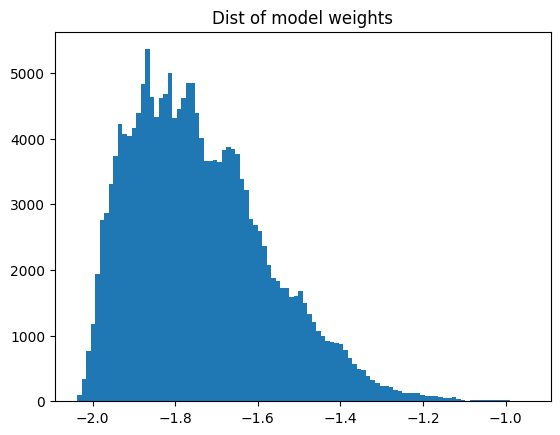

Outer epoch 44, Inner epoch 10, Loss: 	Avg Corr: 0.3045, Corr: 0.5481, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3089, Corr: 0.5557, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9862937331199646
Outer epoch 44, Inner epoch 20, Loss: 	Avg Corr: 0.3009, Corr: 0.5396, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3089, Corr: 0.5557, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9710075259208679
Outer epoch 44, Inner epoch 30, Loss: 	Avg Corr: 0.3005, Corr: 0.5386, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3089, Corr: 0.5557, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9692789912223816
Outer epoch 44, Inner epoch 40, Loss: 	Avg Corr: 0.3008, Corr: 0.5390, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3089, Corr: 0.5557, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9699545502662659
Outer epoch 44, Inner epoch 50, Loss: 	Avg Corr: 0.3010, Corr: 0.5394, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.308

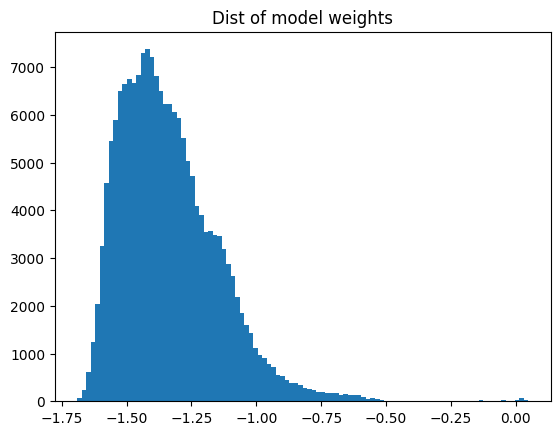

Outer epoch 45, Inner epoch 10, Loss: 	Avg Corr: 0.2929, Corr: 0.5928, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2994, Corr: 0.5982, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9910500645637512
Outer epoch 45, Inner epoch 20, Loss: 	Avg Corr: 0.2917, Corr: 0.5922, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2994, Corr: 0.5982, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9899650812149048
Outer epoch 45, Inner epoch 30, Loss: 	Avg Corr: 0.2917, Corr: 0.5928, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2994, Corr: 0.5982, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9910414218902588
Outer epoch 45, Inner epoch 40, Loss: 	Avg Corr: 0.2919, Corr: 0.5935, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2994, Corr: 0.5982, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9921225309371948
Outer epoch 45, Inner epoch 50, Loss: 	Avg Corr: 0.2921, Corr: 0.5940, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.299

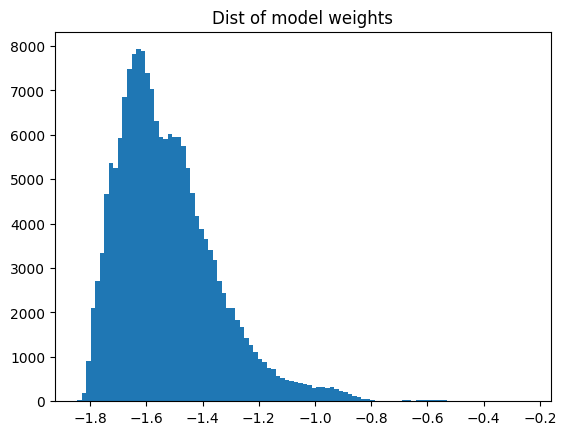

Outer epoch 46, Inner epoch 10, Loss: 	Avg Corr: 0.2971, Corr: 0.5343, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2902, Corr: 0.5265, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0147743225097656
Outer epoch 46, Inner epoch 20, Loss: 	Avg Corr: 0.2963, Corr: 0.5440, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2902, Corr: 0.5265, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0331182479858398
Outer epoch 46, Inner epoch 30, Loss: 	Avg Corr: 0.2964, Corr: 0.5473, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2902, Corr: 0.5265, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0394723415374756
Outer epoch 46, Inner epoch 40, Loss: 	Avg Corr: 0.2969, Corr: 0.5500, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2902, Corr: 0.5265, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0444828271865845
Outer epoch 46, Inner epoch 50, Loss: 	Avg Corr: 0.2976, Corr: 0.5526, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.290

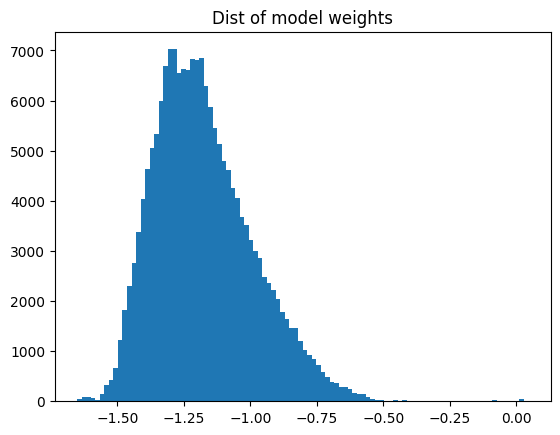

Outer epoch 47, Inner epoch 10, Loss: 	Avg Corr: 0.2480, Corr: 0.6030, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2688, Corr: 0.4297, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.4032714366912842
Outer epoch 47, Inner epoch 20, Loss: 	Avg Corr: 0.2543, Corr: 0.6228, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2688, Corr: 0.4297, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.44935941696167
Outer epoch 47, Inner epoch 30, Loss: 	Avg Corr: 0.2556, Corr: 0.6248, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2688, Corr: 0.4297, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.4541378021240234
Outer epoch 47, Inner epoch 40, Loss: 	Avg Corr: 0.2561, Corr: 0.6255, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2688, Corr: 0.4297, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.4557470083236694
Outer epoch 47, Inner epoch 50, Loss: 	Avg Corr: 0.2563, Corr: 0.6259, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2688,

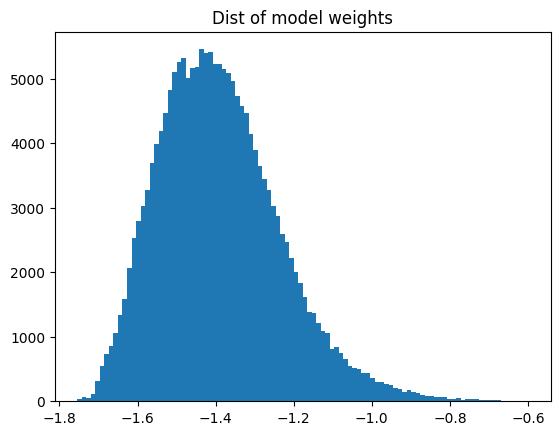

Outer epoch 48, Inner epoch 10, Loss: 	Avg Corr: 0.2534, Corr: 0.4720, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2423, Corr: 0.4511, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0463149547576904
Outer epoch 48, Inner epoch 20, Loss: 	Avg Corr: 0.2629, Corr: 0.4973, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2423, Corr: 0.4511, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.10233473777771
Outer epoch 48, Inner epoch 30, Loss: 	Avg Corr: 0.2647, Corr: 0.5022, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2423, Corr: 0.4511, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1131988763809204
Outer epoch 48, Inner epoch 40, Loss: 	Avg Corr: 0.2645, Corr: 0.5017, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2423, Corr: 0.4511, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1121373176574707
Outer epoch 48, Inner epoch 50, Loss: 	Avg Corr: 0.2636, Corr: 0.4992, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2423,

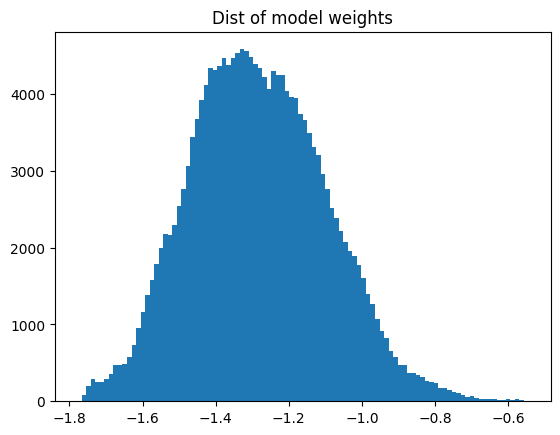

Outer epoch 49, Inner epoch 10, Loss: 	Avg Corr: 0.3097, Corr: 0.6051, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2702, Corr: 0.4839, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.2505115270614624
Outer epoch 49, Inner epoch 20, Loss: 	Avg Corr: 0.3195, Corr: 0.6375, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2702, Corr: 0.4839, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.3175147771835327
Outer epoch 49, Inner epoch 30, Loss: 	Avg Corr: 0.3198, Corr: 0.6387, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2702, Corr: 0.4839, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.3198044300079346
Outer epoch 49, Inner epoch 40, Loss: 	Avg Corr: 0.3188, Corr: 0.6354, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2702, Corr: 0.4839, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.3130650520324707
Outer epoch 49, Inner epoch 50, Loss: 	Avg Corr: 0.3177, Corr: 0.6317, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.270

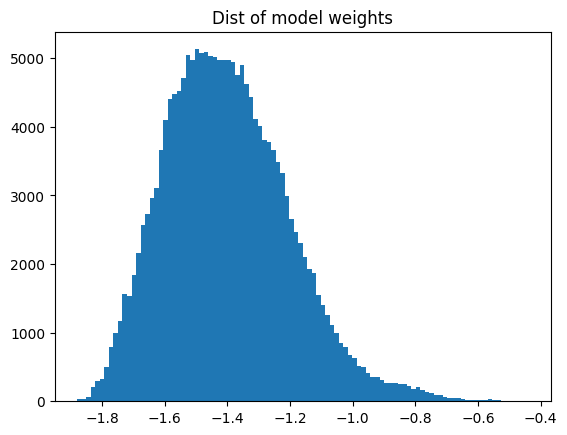

Outer epoch 50, Inner epoch 10, Loss: 	Avg Corr: 0.2841, Corr: 0.6084, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2725, Corr: 0.4497, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.3529891967773438
Outer epoch 50, Inner epoch 20, Loss: 	Avg Corr: 0.2963, Corr: 0.6564, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2725, Corr: 0.4497, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.459688663482666
Outer epoch 50, Inner epoch 30, Loss: 	Avg Corr: 0.2963, Corr: 0.6548, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2725, Corr: 0.4497, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.4561259746551514
Outer epoch 50, Inner epoch 40, Loss: 	Avg Corr: 0.2939, Corr: 0.6450, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2725, Corr: 0.4497, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.4342879056930542
Outer epoch 50, Inner epoch 50, Loss: 	Avg Corr: 0.2906, Corr: 0.6314, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2725

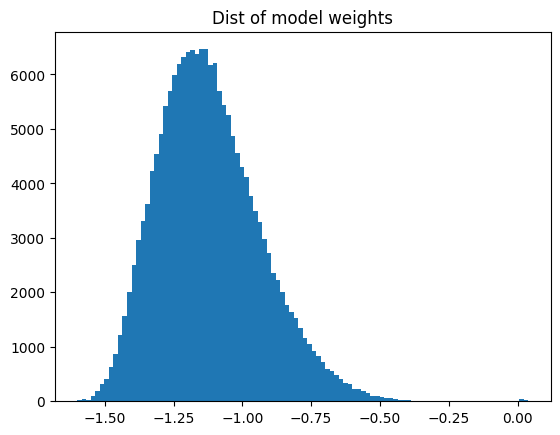

Outer epoch 51, Inner epoch 10, Loss: 	Avg Corr: 0.2455, Corr: 0.4870, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2777, Corr: 0.5331, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9136174321174622
Outer epoch 51, Inner epoch 20, Loss: 	Avg Corr: 0.2493, Corr: 0.5091, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2777, Corr: 0.5331, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9550257921218872
Outer epoch 51, Inner epoch 30, Loss: 	Avg Corr: 0.2495, Corr: 0.5105, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2777, Corr: 0.5331, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9576679468154907
Outer epoch 51, Inner epoch 40, Loss: 	Avg Corr: 0.2488, Corr: 0.5067, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2777, Corr: 0.5331, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9506371021270752
Outer epoch 51, Inner epoch 50, Loss: 	Avg Corr: 0.2481, Corr: 0.5027, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.277

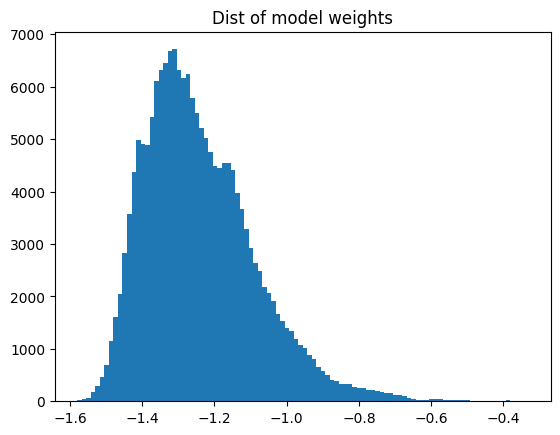

Outer epoch 52, Inner epoch 10, Loss: 	Avg Corr: 0.2961, Corr: 0.5359, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2961, Corr: 0.5414, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9898160696029663
Outer epoch 52, Inner epoch 20, Loss: 	Avg Corr: 0.2987, Corr: 0.5773, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2961, Corr: 0.5414, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0661885738372803
Outer epoch 52, Inner epoch 30, Loss: 	Avg Corr: 0.2972, Corr: 0.5774, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2961, Corr: 0.5414, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.066441297531128
Outer epoch 52, Inner epoch 40, Loss: 	Avg Corr: 0.2951, Corr: 0.5679, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2961, Corr: 0.5414, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0488405227661133
Outer epoch 52, Inner epoch 50, Loss: 	Avg Corr: 0.2930, Corr: 0.5553, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2961

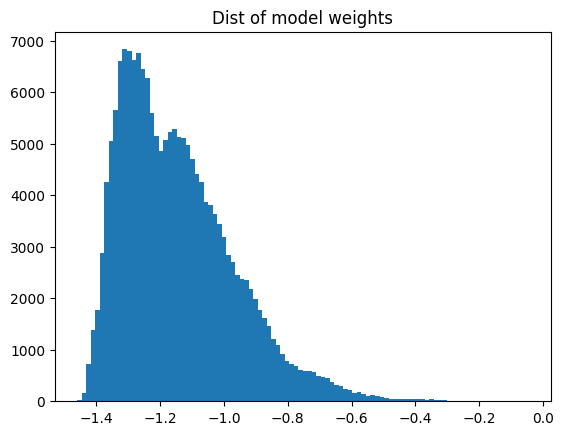

Outer epoch 53, Inner epoch 10, Loss: 	Avg Corr: 0.2601, Corr: 0.4241, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2796, Corr: 0.4456, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9516691565513611
Outer epoch 53, Inner epoch 20, Loss: 	Avg Corr: 0.2651, Corr: 0.4458, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2796, Corr: 0.4456, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0004469156265259
Outer epoch 53, Inner epoch 30, Loss: 	Avg Corr: 0.2654, Corr: 0.4490, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2796, Corr: 0.4456, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0076375007629395
Outer epoch 53, Inner epoch 40, Loss: 	Avg Corr: 0.2646, Corr: 0.4474, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2796, Corr: 0.4456, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0041217803955078
Outer epoch 53, Inner epoch 50, Loss: 	Avg Corr: 0.2647, Corr: 0.4468, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.279

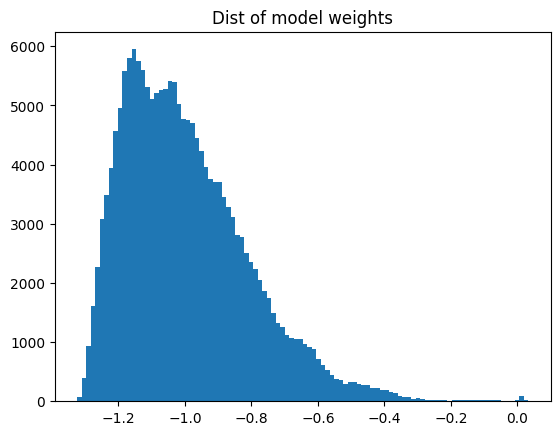

Outer epoch 54, Inner epoch 10, Loss: 	Avg Corr: 0.2711, Corr: 0.4697, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2760, Corr: 0.4824, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9736929535865784
Outer epoch 54, Inner epoch 20, Loss: 	Avg Corr: 0.2662, Corr: 0.4588, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2760, Corr: 0.4824, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9511501789093018
Outer epoch 54, Inner epoch 30, Loss: 	Avg Corr: 0.2641, Corr: 0.4552, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2760, Corr: 0.4824, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9436689019203186
Outer epoch 54, Inner epoch 40, Loss: 	Avg Corr: 0.2629, Corr: 0.4540, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2760, Corr: 0.4824, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9412182569503784
Outer epoch 54, Inner epoch 50, Loss: 	Avg Corr: 0.2616, Corr: 0.4531, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.276

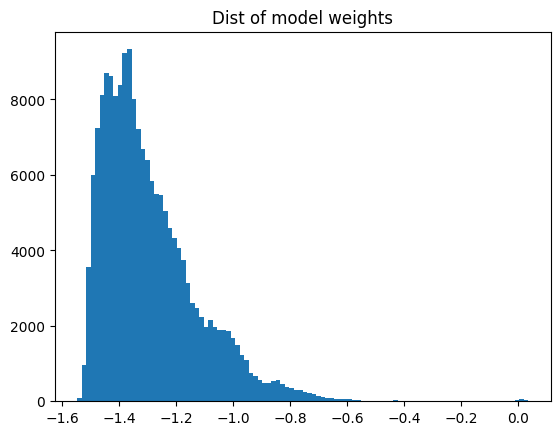

Outer epoch 55, Inner epoch 10, Loss: 	Avg Corr: 0.2352, Corr: 0.3465, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2596, Corr: 0.4026, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8605687618255615
Outer epoch 55, Inner epoch 20, Loss: 	Avg Corr: 0.2319, Corr: 0.3378, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2596, Corr: 0.4026, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8391605615615845
Outer epoch 55, Inner epoch 30, Loss: 	Avg Corr: 0.2315, Corr: 0.3386, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2596, Corr: 0.4026, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8409594297409058
Outer epoch 55, Inner epoch 40, Loss: 	Avg Corr: 0.2323, Corr: 0.3419, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2596, Corr: 0.4026, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.849189281463623
Outer epoch 55, Inner epoch 50, Loss: 	Avg Corr: 0.2336, Corr: 0.3468, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2596

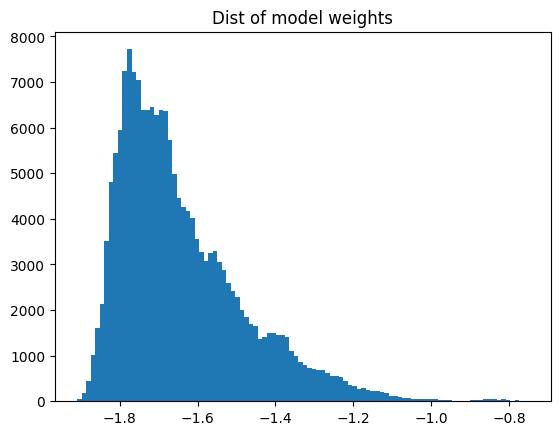

Outer epoch 56, Inner epoch 10, Loss: 	Avg Corr: 0.3001, Corr: 0.6710, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3105, Corr: 0.6567, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.021916389465332
Outer epoch 56, Inner epoch 20, Loss: 	Avg Corr: 0.3134, Corr: 0.7204, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3105, Corr: 0.6567, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0970357656478882
Outer epoch 56, Inner epoch 30, Loss: 	Avg Corr: 0.3220, Corr: 0.7452, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3105, Corr: 0.6567, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1348061561584473
Outer epoch 56, Inner epoch 40, Loss: 	Avg Corr: 0.3269, Corr: 0.7611, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3105, Corr: 0.6567, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.159028172492981
Outer epoch 56, Inner epoch 50, Loss: 	Avg Corr: 0.3296, Corr: 0.7706, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3105,

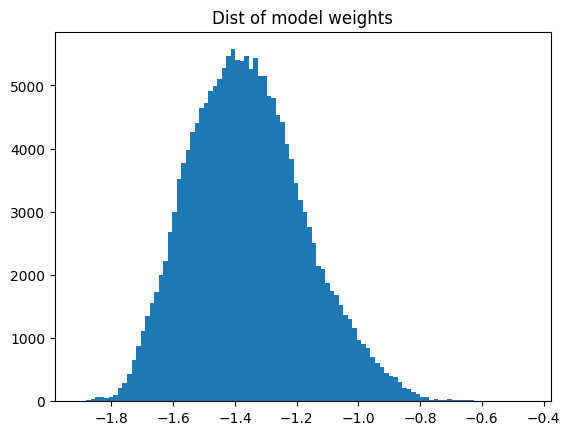

Outer epoch 57, Inner epoch 10, Loss: 	Avg Corr: 0.2691, Corr: 0.4829, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2708, Corr: 0.5035, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9590432047843933
Outer epoch 57, Inner epoch 20, Loss: 	Avg Corr: 0.2659, Corr: 0.4804, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2708, Corr: 0.5035, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9540014863014221
Outer epoch 57, Inner epoch 30, Loss: 	Avg Corr: 0.2651, Corr: 0.4795, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2708, Corr: 0.5035, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9523464441299438
Outer epoch 57, Inner epoch 40, Loss: 	Avg Corr: 0.2648, Corr: 0.4792, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2708, Corr: 0.5035, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9516965746879578
Outer epoch 57, Inner epoch 50, Loss: 	Avg Corr: 0.2647, Corr: 0.4791, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.270

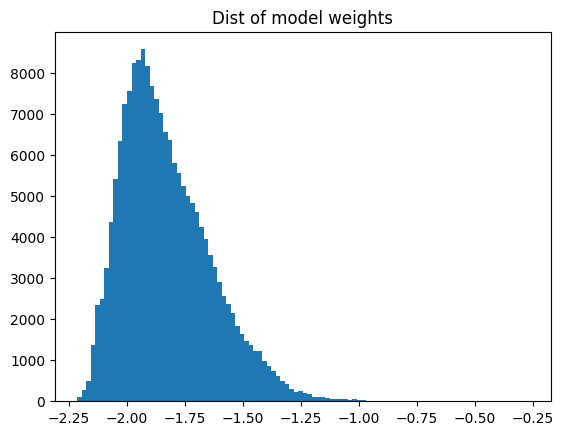

Outer epoch 58, Inner epoch 10, Loss: 	Avg Corr: 0.4903, Corr: 1.3933, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3121, Corr: 0.5749, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 2.4235236644744873
Outer epoch 58, Inner epoch 20, Loss: 	Avg Corr: 0.4886, Corr: 1.3876, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3121, Corr: 0.5749, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 2.4135518074035645
Outer epoch 58, Inner epoch 30, Loss: 	Avg Corr: 0.4830, Corr: 1.3635, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3121, Corr: 0.5749, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 2.3716928958892822
Outer epoch 58, Inner epoch 40, Loss: 	Avg Corr: 0.4738, Corr: 1.3237, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3121, Corr: 0.5749, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 2.3024373054504395
Outer epoch 58, Inner epoch 50, Loss: 	Avg Corr: 0.4612, Corr: 1.2660, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.312

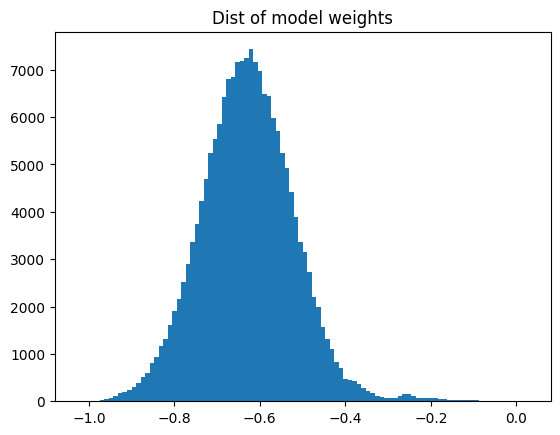

Outer epoch 59, Inner epoch 10, Loss: 	Avg Corr: 0.3779, Corr: 0.9758, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3122, Corr: 0.5540, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.761214256286621
Outer epoch 59, Inner epoch 20, Loss: 	Avg Corr: 0.3641, Corr: 0.8991, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3122, Corr: 0.5540, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.622766137123108
Outer epoch 59, Inner epoch 30, Loss: 	Avg Corr: 0.3369, Corr: 0.7350, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3122, Corr: 0.5540, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.326554775238037
Outer epoch 59, Inner epoch 40, Loss: 	Avg Corr: 0.3032, Corr: 0.5607, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3122, Corr: 0.5540, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0120635032653809
Outer epoch 59, Inner epoch 50, Loss: 	Avg Corr: 0.2707, Corr: 0.4411, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3122, 

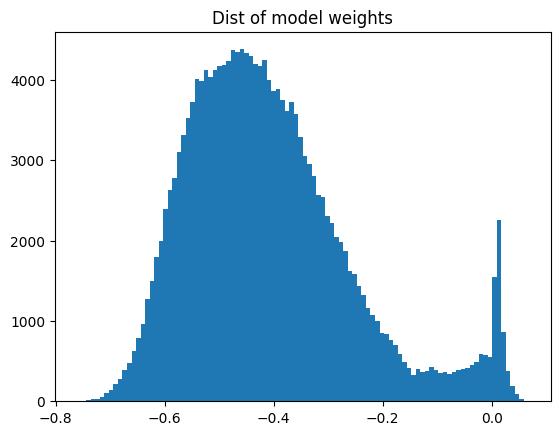

Outer epoch 60, Inner epoch 10, Loss: 	Avg Corr: 0.2529, Corr: 0.4259, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2491, Corr: 0.4459, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9551872611045837
Outer epoch 60, Inner epoch 20, Loss: 	Avg Corr: 0.2811, Corr: 0.5017, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2491, Corr: 0.4459, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1251353025436401
Outer epoch 60, Inner epoch 30, Loss: 	Avg Corr: 0.2840, Corr: 0.5102, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2491, Corr: 0.4459, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1443315744400024
Outer epoch 60, Inner epoch 40, Loss: 	Avg Corr: 0.2804, Corr: 0.5023, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2491, Corr: 0.4459, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1265103816986084
Outer epoch 60, Inner epoch 50, Loss: 	Avg Corr: 0.2790, Corr: 0.4992, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.249

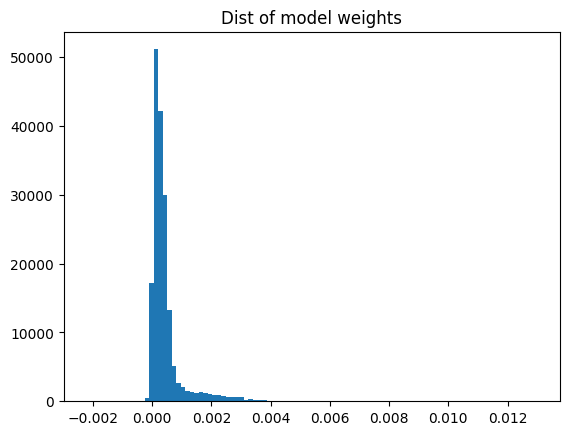

Outer epoch 61, Inner epoch 10, Loss: 	Avg Corr: 0.2891, Corr: 0.5424, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3040, Corr: 0.6164, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8799831867218018
Outer epoch 61, Inner epoch 20, Loss: 	Avg Corr: 0.2866, Corr: 0.5328, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3040, Corr: 0.6164, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8644128441810608
Outer epoch 61, Inner epoch 30, Loss: 	Avg Corr: 0.2865, Corr: 0.5321, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3040, Corr: 0.6164, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8632060885429382
Outer epoch 61, Inner epoch 40, Loss: 	Avg Corr: 0.2864, Corr: 0.5318, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3040, Corr: 0.6164, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8627834320068359
Outer epoch 61, Inner epoch 50, Loss: 	Avg Corr: 0.2864, Corr: 0.5317, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.304

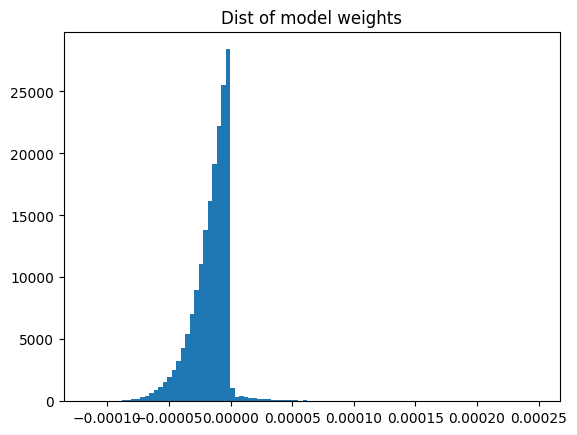

Outer epoch 62, Inner epoch 10, Loss: 	Avg Corr: 0.3024, Corr: 0.5740, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2859, Corr: 0.5216, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1005538702011108
Outer epoch 62, Inner epoch 20, Loss: 	Avg Corr: 0.3011, Corr: 0.5722, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2859, Corr: 0.5216, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.097105860710144
Outer epoch 62, Inner epoch 30, Loss: 	Avg Corr: 0.3005, Corr: 0.5686, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2859, Corr: 0.5216, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.090130090713501
Outer epoch 62, Inner epoch 40, Loss: 	Avg Corr: 0.3001, Corr: 0.5666, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2859, Corr: 0.5216, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0863577127456665
Outer epoch 62, Inner epoch 50, Loss: 	Avg Corr: 0.2999, Corr: 0.5655, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2859,

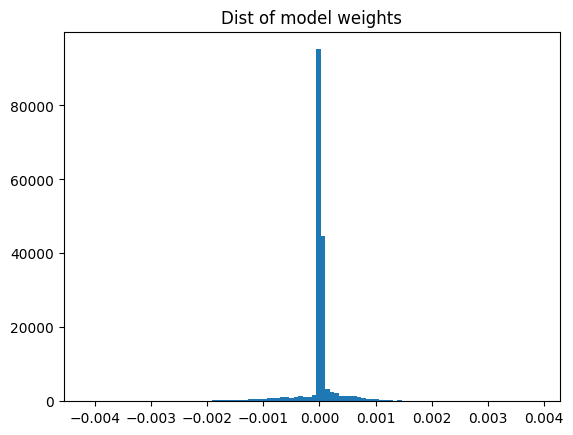

Outer epoch 63, Inner epoch 10, Loss: 	Avg Corr: 0.2772, Corr: 0.4432, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2799, Corr: 0.4734, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9360843300819397
Outer epoch 63, Inner epoch 20, Loss: 	Avg Corr: 0.2760, Corr: 0.4428, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2799, Corr: 0.4734, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9352933168411255
Outer epoch 63, Inner epoch 30, Loss: 	Avg Corr: 0.2759, Corr: 0.4425, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2799, Corr: 0.4734, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9347241520881653
Outer epoch 63, Inner epoch 40, Loss: 	Avg Corr: 0.2758, Corr: 0.4424, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2799, Corr: 0.4734, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9345271587371826
Outer epoch 63, Inner epoch 50, Loss: 	Avg Corr: 0.2758, Corr: 0.4424, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.279

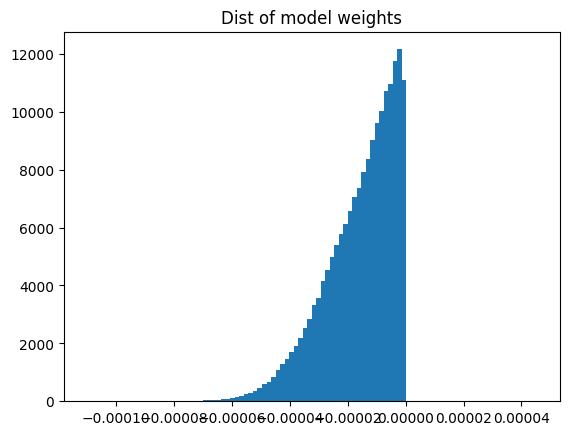

Outer epoch 64, Inner epoch 10, Loss: 	Avg Corr: 0.2621, Corr: 0.4883, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3031, Corr: 0.5615, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8697214126586914
Outer epoch 64, Inner epoch 20, Loss: 	Avg Corr: 0.2661, Corr: 0.4939, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3031, Corr: 0.5615, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8796886801719666
Outer epoch 64, Inner epoch 30, Loss: 	Avg Corr: 0.2667, Corr: 0.4948, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3031, Corr: 0.5615, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8811925649642944
Outer epoch 64, Inner epoch 40, Loss: 	Avg Corr: 0.2669, Corr: 0.4951, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3031, Corr: 0.5615, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8817421197891235
Outer epoch 64, Inner epoch 50, Loss: 	Avg Corr: 0.2670, Corr: 0.4952, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.303

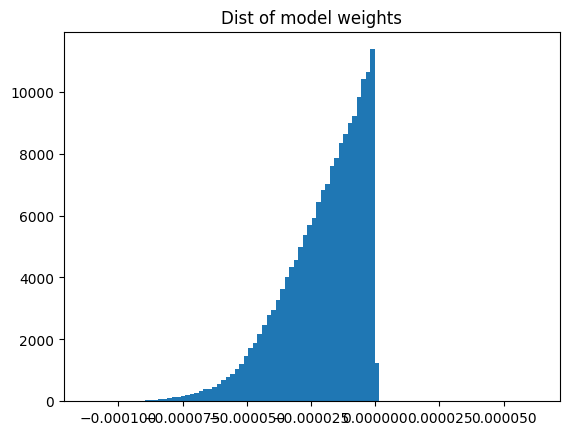

Outer epoch 65, Inner epoch 10, Loss: 	Avg Corr: 0.2723, Corr: 0.5087, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2816, Corr: 0.5091, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9991745352745056
Outer epoch 65, Inner epoch 20, Loss: 	Avg Corr: 0.2737, Corr: 0.5146, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2816, Corr: 0.5091, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0106672048568726
Outer epoch 65, Inner epoch 30, Loss: 	Avg Corr: 0.2739, Corr: 0.5151, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2816, Corr: 0.5091, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0116803646087646
Outer epoch 65, Inner epoch 40, Loss: 	Avg Corr: 0.2739, Corr: 0.5153, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2816, Corr: 0.5091, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0120396614074707
Outer epoch 65, Inner epoch 50, Loss: 	Avg Corr: 0.2739, Corr: 0.5153, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.281

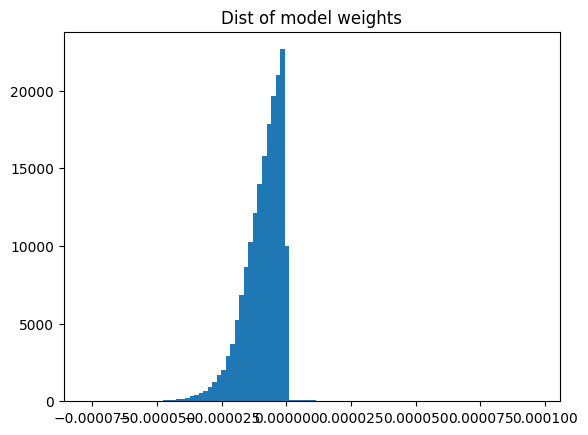

Outer epoch 66, Inner epoch 10, Loss: 	Avg Corr: 0.2402, Corr: 0.3918, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2659, Corr: 0.4300, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9112147688865662
Outer epoch 66, Inner epoch 20, Loss: 	Avg Corr: 0.2422, Corr: 0.3940, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2659, Corr: 0.4300, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9163272976875305
Outer epoch 66, Inner epoch 30, Loss: 	Avg Corr: 0.2423, Corr: 0.3941, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2659, Corr: 0.4300, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9165099859237671
Outer epoch 66, Inner epoch 40, Loss: 	Avg Corr: 0.2423, Corr: 0.3941, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2659, Corr: 0.4300, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9165449142456055
Outer epoch 66, Inner epoch 50, Loss: 	Avg Corr: 0.2423, Corr: 0.3942, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.265

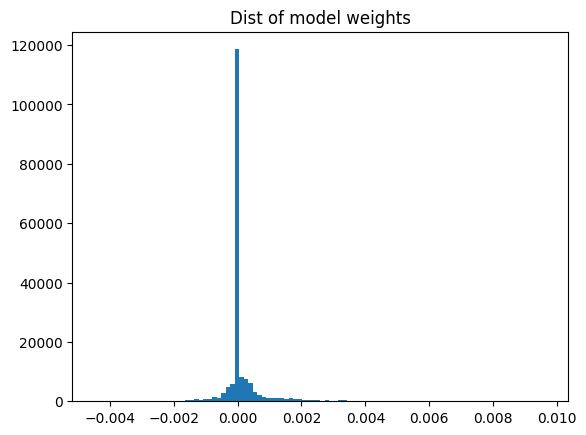

Outer epoch 67, Inner epoch 10, Loss: 	Avg Corr: 0.3735, Corr: 0.7648, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3789, Corr: 0.7827, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9771629571914673
Outer epoch 67, Inner epoch 20, Loss: 	Avg Corr: 0.3736, Corr: 0.7663, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3789, Corr: 0.7827, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.979030430316925
Outer epoch 67, Inner epoch 30, Loss: 	Avg Corr: 0.3735, Corr: 0.7661, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3789, Corr: 0.7827, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9787877202033997
Outer epoch 67, Inner epoch 40, Loss: 	Avg Corr: 0.3735, Corr: 0.7660, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3789, Corr: 0.7827, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9787175059318542
Outer epoch 67, Inner epoch 50, Loss: 	Avg Corr: 0.3735, Corr: 0.7660, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3789

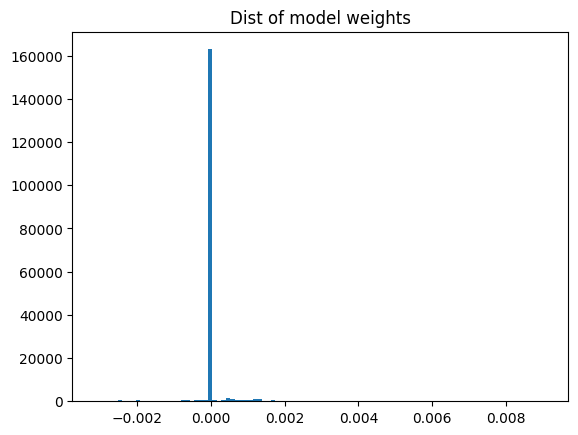

Outer epoch 68, Inner epoch 10, Loss: 	Avg Corr: 0.3189, Corr: 0.6217, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3890, Corr: 0.8498, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.731621265411377
Outer epoch 68, Inner epoch 20, Loss: 	Avg Corr: 0.3166, Corr: 0.6128, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3890, Corr: 0.8498, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.7211529612541199
Outer epoch 68, Inner epoch 30, Loss: 	Avg Corr: 0.3161, Corr: 0.6113, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3890, Corr: 0.8498, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.7193535566329956
Outer epoch 68, Inner epoch 40, Loss: 	Avg Corr: 0.3158, Corr: 0.6100, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3890, Corr: 0.8498, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.7177733778953552
Outer epoch 68, Inner epoch 50, Loss: 	Avg Corr: 0.3152, Corr: 0.6088, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3890

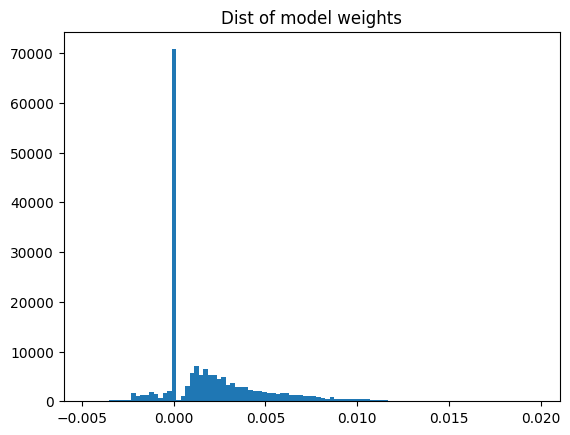

Outer epoch 69, Inner epoch 10, Loss: 	Avg Corr: 0.3729, Corr: 0.8139, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3422, Corr: 0.7141, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1398552656173706
Outer epoch 69, Inner epoch 20, Loss: 	Avg Corr: 0.3761, Corr: 0.8262, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3422, Corr: 0.7141, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1569947004318237
Outer epoch 69, Inner epoch 30, Loss: 	Avg Corr: 0.3761, Corr: 0.8265, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3422, Corr: 0.7141, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1574558019638062
Outer epoch 69, Inner epoch 40, Loss: 	Avg Corr: 0.3761, Corr: 0.8268, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3422, Corr: 0.7141, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1578627824783325
Outer epoch 69, Inner epoch 50, Loss: 	Avg Corr: 0.3762, Corr: 0.8272, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.342

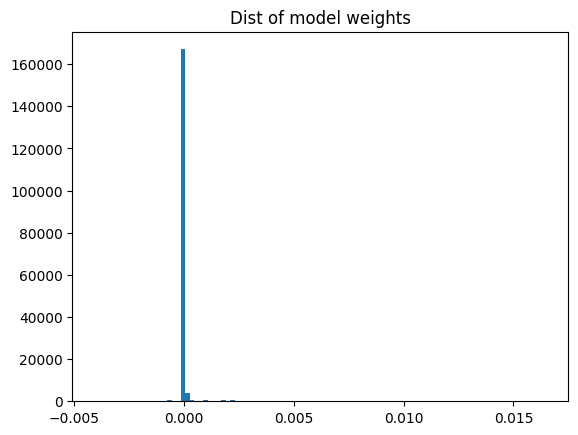

Outer epoch 70, Inner epoch 10, Loss: 	Avg Corr: 0.2499, Corr: 0.4235, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2933, Corr: 0.5728, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.7392852902412415
Outer epoch 70, Inner epoch 20, Loss: 	Avg Corr: 0.2485, Corr: 0.4181, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2933, Corr: 0.5728, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.7299840450286865
Outer epoch 70, Inner epoch 30, Loss: 	Avg Corr: 0.2438, Corr: 0.4104, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2933, Corr: 0.5728, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.7164276838302612
Outer epoch 70, Inner epoch 40, Loss: 	Avg Corr: 0.2379, Corr: 0.3999, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2933, Corr: 0.5728, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.6981439590454102
Outer epoch 70, Inner epoch 50, Loss: 	Avg Corr: 0.2347, Corr: 0.3963, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.293

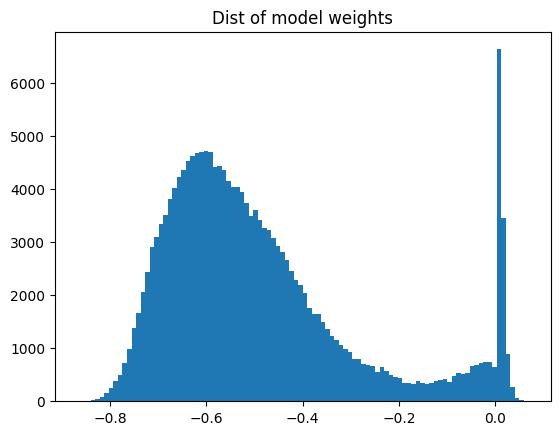

Outer epoch 71, Inner epoch 10, Loss: 	Avg Corr: 0.2530, Corr: 0.4232, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2883, Corr: 0.5093, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8308858275413513
Outer epoch 71, Inner epoch 20, Loss: 	Avg Corr: 0.2607, Corr: 0.4438, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2883, Corr: 0.5093, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8713593482971191
Outer epoch 71, Inner epoch 30, Loss: 	Avg Corr: 0.2657, Corr: 0.4604, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2883, Corr: 0.5093, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9039314389228821
Outer epoch 71, Inner epoch 40, Loss: 	Avg Corr: 0.2654, Corr: 0.4667, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2883, Corr: 0.5093, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9163292050361633
Outer epoch 71, Inner epoch 50, Loss: 	Avg Corr: 0.2650, Corr: 0.4750, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.288

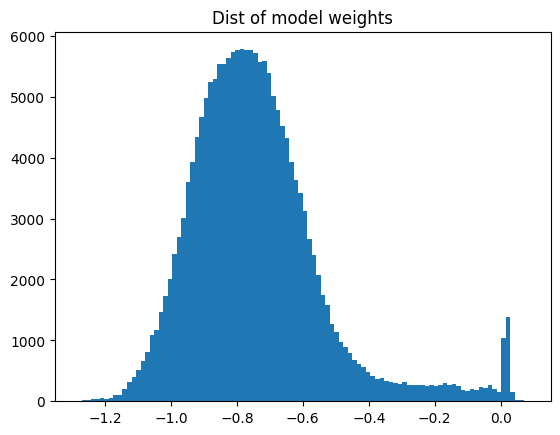

Outer epoch 72, Inner epoch 10, Loss: 	Avg Corr: 0.3369, Corr: 0.6906, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2618, Corr: 0.4482, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.5406091213226318
Outer epoch 72, Inner epoch 20, Loss: 	Avg Corr: 0.3544, Corr: 0.7685, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2617, Corr: 0.4482, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.7145411968231201
Outer epoch 72, Inner epoch 30, Loss: 	Avg Corr: 0.3664, Corr: 0.8216, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2618, Corr: 0.4482, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.8328391313552856
Outer epoch 72, Inner epoch 40, Loss: 	Avg Corr: 0.3732, Corr: 0.8530, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2618, Corr: 0.4482, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.9030086994171143
Outer epoch 72, Inner epoch 50, Loss: 	Avg Corr: 0.3785, Corr: 0.8796, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.261

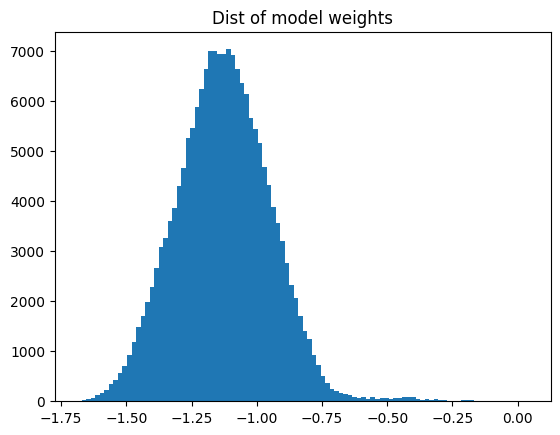

Outer epoch 73, Inner epoch 10, Loss: 	Avg Corr: 0.2848, Corr: 0.4968, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2756, Corr: 0.4838, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.026960015296936
Outer epoch 73, Inner epoch 20, Loss: 	Avg Corr: 0.2873, Corr: 0.5127, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2756, Corr: 0.4838, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0597586631774902
Outer epoch 73, Inner epoch 30, Loss: 	Avg Corr: 0.2880, Corr: 0.5176, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2756, Corr: 0.4838, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0699689388275146
Outer epoch 73, Inner epoch 40, Loss: 	Avg Corr: 0.2887, Corr: 0.5213, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2756, Corr: 0.4838, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0776104927062988
Outer epoch 73, Inner epoch 50, Loss: 	Avg Corr: 0.2893, Corr: 0.5243, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2756

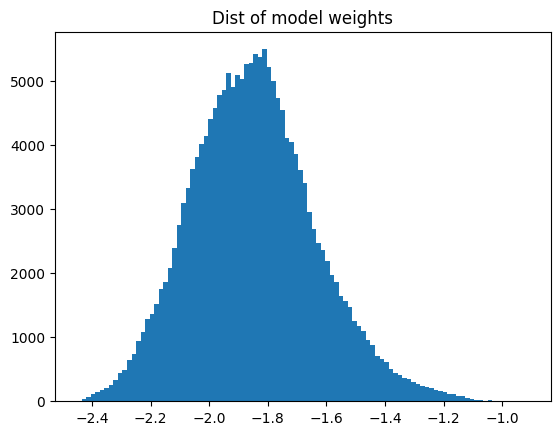

Outer epoch 74, Inner epoch 10, Loss: 	Avg Corr: 0.3344, Corr: 0.7922, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3319, Corr: 0.7048, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1240450143814087
Outer epoch 74, Inner epoch 20, Loss: 	Avg Corr: 0.3343, Corr: 0.8039, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3319, Corr: 0.7048, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1406404972076416
Outer epoch 74, Inner epoch 30, Loss: 	Avg Corr: 0.3353, Corr: 0.8078, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3319, Corr: 0.7048, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1461206674575806
Outer epoch 74, Inner epoch 40, Loss: 	Avg Corr: 0.3360, Corr: 0.8107, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3319, Corr: 0.7048, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1502231359481812
Outer epoch 74, Inner epoch 50, Loss: 	Avg Corr: 0.3366, Corr: 0.8131, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.331

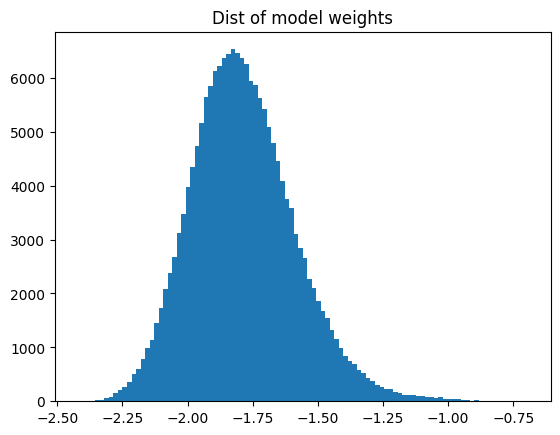

Outer epoch 75, Inner epoch 10, Loss: 	Avg Corr: 0.3239, Corr: 0.6530, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2739, Corr: 0.4383, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.4899002313613892
Outer epoch 75, Inner epoch 20, Loss: 	Avg Corr: 0.3355, Corr: 0.6995, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2739, Corr: 0.4383, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.5961580276489258
Outer epoch 75, Inner epoch 30, Loss: 	Avg Corr: 0.3372, Corr: 0.7081, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2739, Corr: 0.4383, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.6157617568969727
Outer epoch 75, Inner epoch 40, Loss: 	Avg Corr: 0.3376, Corr: 0.7119, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2739, Corr: 0.4383, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.6243977546691895
Outer epoch 75, Inner epoch 50, Loss: 	Avg Corr: 0.3387, Corr: 0.7163, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.273

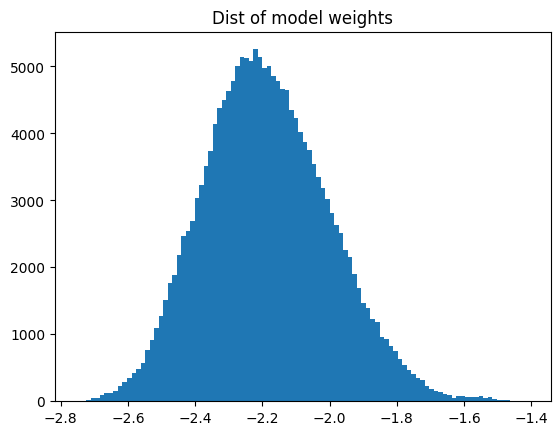

Outer epoch 76, Inner epoch 10, Loss: 	Avg Corr: 0.3338, Corr: 0.6776, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3272, Corr: 0.6206, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0917901992797852
Outer epoch 76, Inner epoch 20, Loss: 	Avg Corr: 0.3342, Corr: 0.6892, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3272, Corr: 0.6206, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1105793714523315
Outer epoch 76, Inner epoch 30, Loss: 	Avg Corr: 0.3347, Corr: 0.6941, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3272, Corr: 0.6206, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1184319257736206
Outer epoch 76, Inner epoch 40, Loss: 	Avg Corr: 0.3353, Corr: 0.6974, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3272, Corr: 0.6206, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1237139701843262
Outer epoch 76, Inner epoch 50, Loss: 	Avg Corr: 0.3360, Corr: 0.7013, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.327

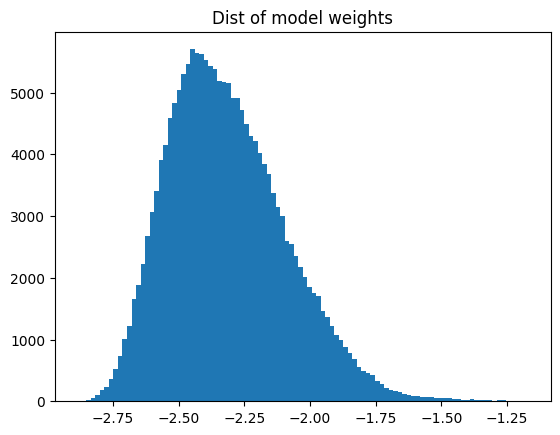

Outer epoch 77, Inner epoch 10, Loss: 	Avg Corr: 0.3537, Corr: 0.8339, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3508, Corr: 0.7875, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.058812141418457
Outer epoch 77, Inner epoch 20, Loss: 	Avg Corr: 0.3564, Corr: 0.8501, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3508, Corr: 0.7875, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0794373750686646
Outer epoch 77, Inner epoch 30, Loss: 	Avg Corr: 0.3578, Corr: 0.8570, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3508, Corr: 0.7875, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0882359743118286
Outer epoch 77, Inner epoch 40, Loss: 	Avg Corr: 0.3590, Corr: 0.8611, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3508, Corr: 0.7875, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.093438982963562
Outer epoch 77, Inner epoch 50, Loss: 	Avg Corr: 0.3598, Corr: 0.8640, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3508,

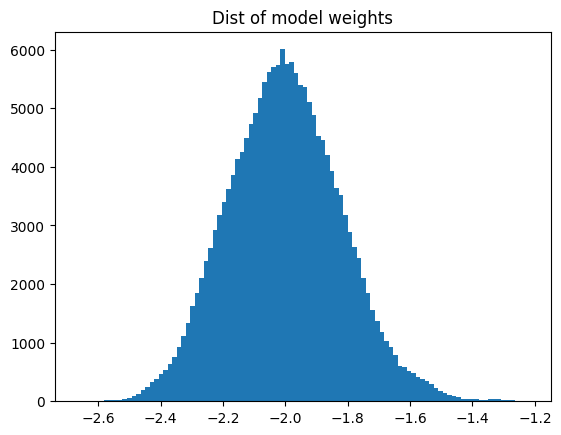

Outer epoch 78, Inner epoch 10, Loss: 	Avg Corr: 0.3491, Corr: 0.8660, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3398, Corr: 0.7431, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1652785539627075
Outer epoch 78, Inner epoch 20, Loss: 	Avg Corr: 0.3507, Corr: 0.8856, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3398, Corr: 0.7431, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1917517185211182
Outer epoch 78, Inner epoch 30, Loss: 	Avg Corr: 0.3512, Corr: 0.8885, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3398, Corr: 0.7431, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1956455707550049
Outer epoch 78, Inner epoch 40, Loss: 	Avg Corr: 0.3518, Corr: 0.8915, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3398, Corr: 0.7431, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1996338367462158
Outer epoch 78, Inner epoch 50, Loss: 	Avg Corr: 0.3524, Corr: 0.8942, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.339

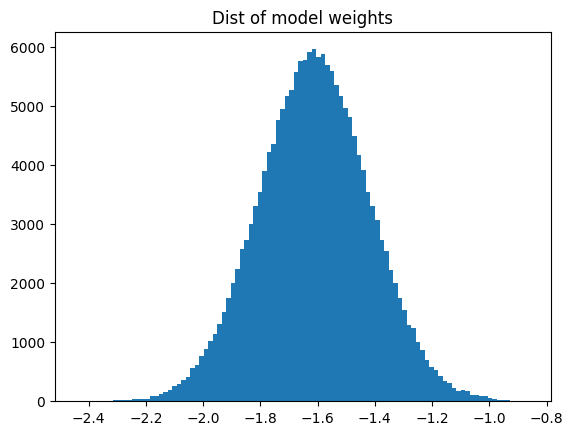

Outer epoch 79, Inner epoch 10, Loss: 	Avg Corr: 0.2952, Corr: 0.6576, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2942, Corr: 0.5168, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.272420883178711
Outer epoch 79, Inner epoch 20, Loss: 	Avg Corr: 0.3135, Corr: 0.7314, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2942, Corr: 0.5168, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.415208101272583
Outer epoch 79, Inner epoch 30, Loss: 	Avg Corr: 0.3184, Corr: 0.7447, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2942, Corr: 0.5168, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.4409141540527344
Outer epoch 79, Inner epoch 40, Loss: 	Avg Corr: 0.3200, Corr: 0.7490, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2942, Corr: 0.5168, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.4492467641830444
Outer epoch 79, Inner epoch 50, Loss: 	Avg Corr: 0.3207, Corr: 0.7511, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2942,

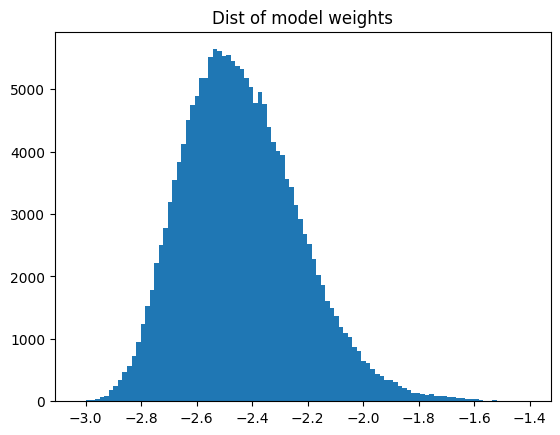

Outer epoch 80, Inner epoch 10, Loss: 	Avg Corr: 0.2734, Corr: 0.6068, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2916, Corr: 0.5841, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0387505292892456
Outer epoch 80, Inner epoch 20, Loss: 	Avg Corr: 0.2889, Corr: 0.6730, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2916, Corr: 0.5841, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1522340774536133
Outer epoch 80, Inner epoch 30, Loss: 	Avg Corr: 0.2774, Corr: 0.6373, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2916, Corr: 0.5841, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0910052061080933
Outer epoch 80, Inner epoch 40, Loss: 	Avg Corr: 0.2796, Corr: 0.6274, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2916, Corr: 0.5841, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.074012279510498
Outer epoch 80, Inner epoch 50, Loss: 	Avg Corr: 0.2727, Corr: 0.5969, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2916

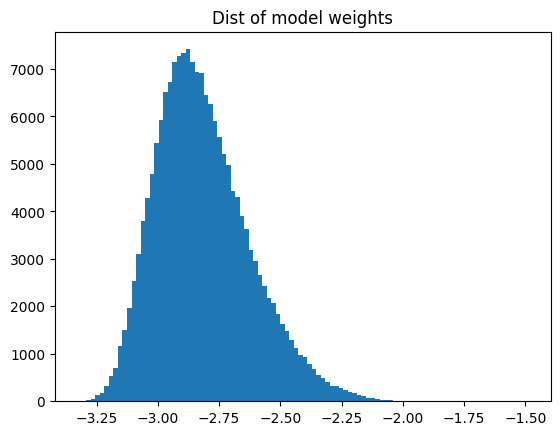

Outer epoch 81, Inner epoch 10, Loss: 	Avg Corr: 0.4518, Corr: 1.1489, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2268, Corr: 0.3154, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 3.6430790424346924
Outer epoch 81, Inner epoch 20, Loss: 	Avg Corr: 0.4760, Corr: 1.2474, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2268, Corr: 0.3154, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 3.95552921295166
Outer epoch 81, Inner epoch 30, Loss: 	Avg Corr: 0.4727, Corr: 1.2332, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2268, Corr: 0.3154, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 3.9104130268096924
Outer epoch 81, Inner epoch 40, Loss: 	Avg Corr: 0.4703, Corr: 1.2210, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2268, Corr: 0.3154, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 3.8718338012695312
Outer epoch 81, Inner epoch 50, Loss: 	Avg Corr: 0.4579, Corr: 1.1692, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2268,

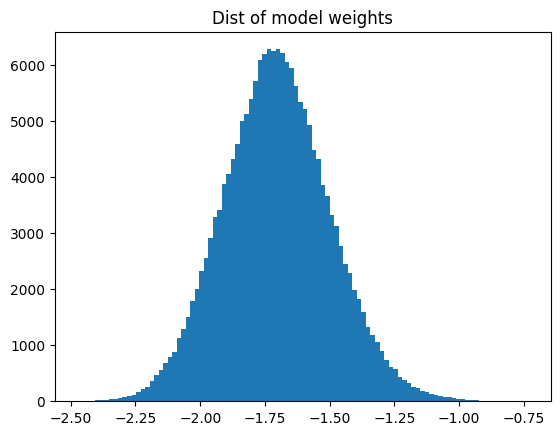

Outer epoch 82, Inner epoch 10, Loss: 	Avg Corr: 0.3082, Corr: 0.6349, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3204, Corr: 0.5762, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.101729393005371
Outer epoch 82, Inner epoch 20, Loss: 	Avg Corr: 0.3091, Corr: 0.6527, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3204, Corr: 0.5762, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1326873302459717
Outer epoch 82, Inner epoch 30, Loss: 	Avg Corr: 0.3085, Corr: 0.6350, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3204, Corr: 0.5762, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1019130945205688
Outer epoch 82, Inner epoch 40, Loss: 	Avg Corr: 0.3046, Corr: 0.6058, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3204, Corr: 0.5762, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0512409210205078
Outer epoch 82, Inner epoch 50, Loss: 	Avg Corr: 0.3034, Corr: 0.5853, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3204

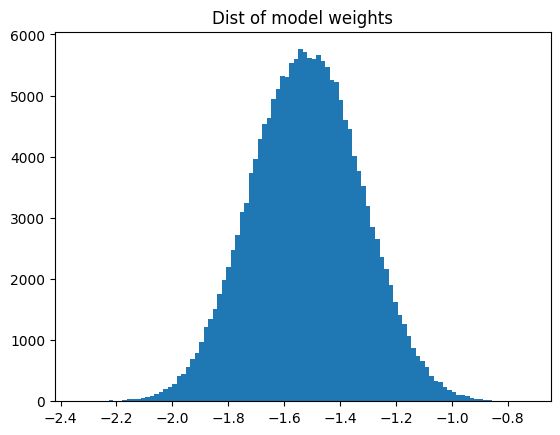

Outer epoch 83, Inner epoch 10, Loss: 	Avg Corr: 0.3432, Corr: 0.7893, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2953, Corr: 0.5631, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.4016255140304565
Outer epoch 83, Inner epoch 20, Loss: 	Avg Corr: 0.3407, Corr: 0.7883, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2953, Corr: 0.5631, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.399951696395874
Outer epoch 83, Inner epoch 30, Loss: 	Avg Corr: 0.3370, Corr: 0.7729, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2953, Corr: 0.5631, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.3725565671920776
Outer epoch 83, Inner epoch 40, Loss: 	Avg Corr: 0.3334, Corr: 0.7591, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2953, Corr: 0.5631, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.3479946851730347
Outer epoch 83, Inner epoch 50, Loss: 	Avg Corr: 0.3298, Corr: 0.7462, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2953

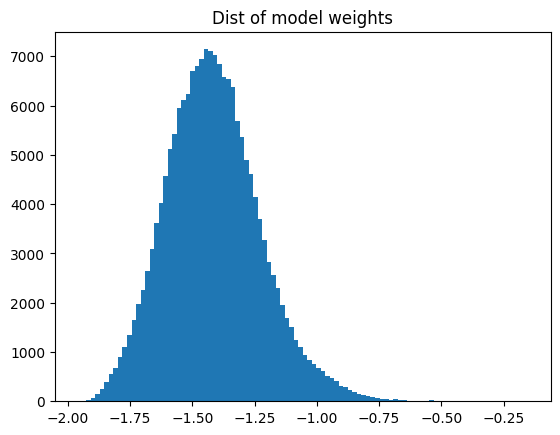

Outer epoch 84, Inner epoch 10, Loss: 	Avg Corr: 0.3403, Corr: 0.6670, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3098, Corr: 0.5574, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1966063976287842
Outer epoch 84, Inner epoch 20, Loss: 	Avg Corr: 0.3391, Corr: 0.6662, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3098, Corr: 0.5574, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1950374841690063
Outer epoch 84, Inner epoch 30, Loss: 	Avg Corr: 0.3373, Corr: 0.6614, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3098, Corr: 0.5574, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1864032745361328
Outer epoch 84, Inner epoch 40, Loss: 	Avg Corr: 0.3360, Corr: 0.6574, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3098, Corr: 0.5574, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.179367184638977
Outer epoch 84, Inner epoch 50, Loss: 	Avg Corr: 0.3345, Corr: 0.6530, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3098

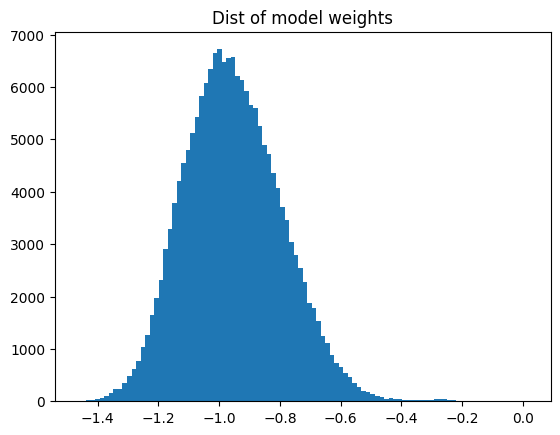

Outer epoch 85, Inner epoch 10, Loss: 	Avg Corr: 0.2574, Corr: 0.4896, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2746, Corr: 0.4589, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.066772699356079
Outer epoch 85, Inner epoch 20, Loss: 	Avg Corr: 0.2589, Corr: 0.4939, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2746, Corr: 0.4589, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.076141357421875
Outer epoch 85, Inner epoch 30, Loss: 	Avg Corr: 0.2585, Corr: 0.4932, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2746, Corr: 0.4589, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0745748281478882
Outer epoch 85, Inner epoch 40, Loss: 	Avg Corr: 0.2583, Corr: 0.4899, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2746, Corr: 0.4589, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.067488193511963
Outer epoch 85, Inner epoch 50, Loss: 	Avg Corr: 0.2589, Corr: 0.4953, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2746, 

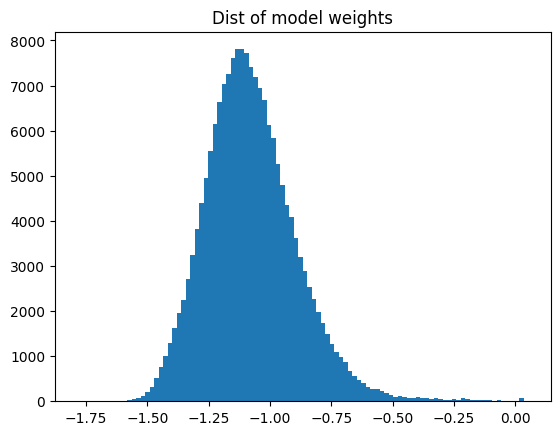

Outer epoch 86, Inner epoch 10, Loss: 	Avg Corr: 0.2003, Corr: 0.2423, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2242, Corr: 0.3036, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.7981240153312683
Outer epoch 86, Inner epoch 20, Loss: 	Avg Corr: 0.1991, Corr: 0.2416, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2242, Corr: 0.3036, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.7956419587135315
Outer epoch 86, Inner epoch 30, Loss: 	Avg Corr: 0.2000, Corr: 0.2441, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2242, Corr: 0.3036, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8039891123771667
Outer epoch 86, Inner epoch 40, Loss: 	Avg Corr: 0.2013, Corr: 0.2472, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2242, Corr: 0.3036, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8140248656272888
Outer epoch 86, Inner epoch 50, Loss: 	Avg Corr: 0.2026, Corr: 0.2505, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.224

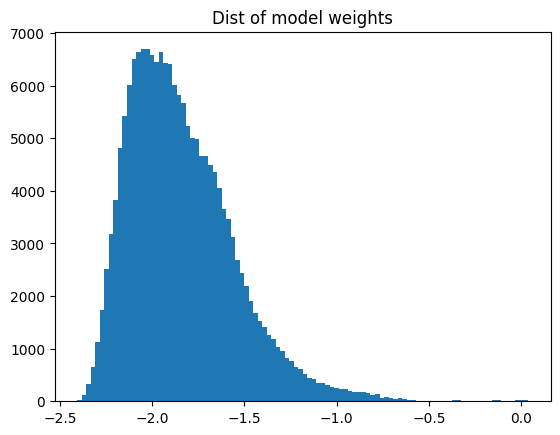

Outer epoch 87, Inner epoch 10, Loss: 	Avg Corr: 0.3082, Corr: 0.6994, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2947, Corr: 0.5880, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.189308762550354
Outer epoch 87, Inner epoch 20, Loss: 	Avg Corr: 0.3094, Corr: 0.7098, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2947, Corr: 0.5880, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.2070469856262207
Outer epoch 87, Inner epoch 30, Loss: 	Avg Corr: 0.3106, Corr: 0.7146, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2947, Corr: 0.5880, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.2151869535446167
Outer epoch 87, Inner epoch 40, Loss: 	Avg Corr: 0.3117, Corr: 0.7185, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2947, Corr: 0.5880, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.2219154834747314
Outer epoch 87, Inner epoch 50, Loss: 	Avg Corr: 0.3125, Corr: 0.7219, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2947

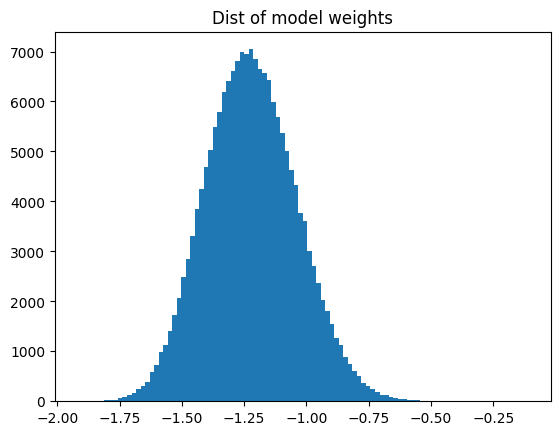

Outer epoch 88, Inner epoch 10, Loss: 	Avg Corr: 0.3078, Corr: 0.5514, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2758, Corr: 0.4352, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.2669214010238647
Outer epoch 88, Inner epoch 20, Loss: 	Avg Corr: 0.3224, Corr: 0.6149, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2758, Corr: 0.4352, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.4127709865570068
Outer epoch 88, Inner epoch 30, Loss: 	Avg Corr: 0.3247, Corr: 0.6258, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2758, Corr: 0.4352, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.4377328157424927
Outer epoch 88, Inner epoch 40, Loss: 	Avg Corr: 0.3256, Corr: 0.6297, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2758, Corr: 0.4352, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.4467319250106812
Outer epoch 88, Inner epoch 50, Loss: 	Avg Corr: 0.3260, Corr: 0.6314, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.275

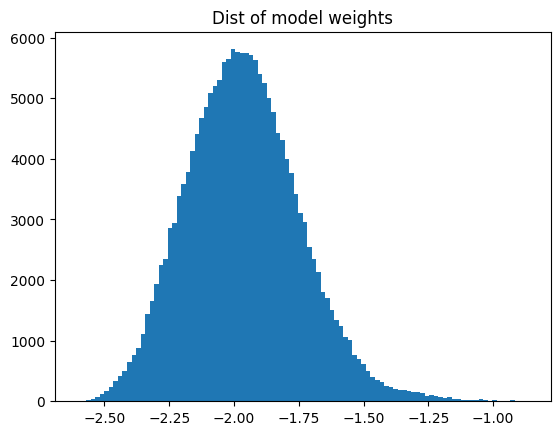

Outer epoch 89, Inner epoch 10, Loss: 	Avg Corr: 0.2787, Corr: 0.5207, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2864, Corr: 0.4964, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0489037036895752
Outer epoch 89, Inner epoch 20, Loss: 	Avg Corr: 0.2844, Corr: 0.5336, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2864, Corr: 0.4964, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0749865770339966
Outer epoch 89, Inner epoch 30, Loss: 	Avg Corr: 0.2851, Corr: 0.5344, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2864, Corr: 0.4964, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0765461921691895
Outer epoch 89, Inner epoch 40, Loss: 	Avg Corr: 0.2853, Corr: 0.5348, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2864, Corr: 0.4964, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.077359676361084
Outer epoch 89, Inner epoch 50, Loss: 	Avg Corr: 0.2854, Corr: 0.5352, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2864

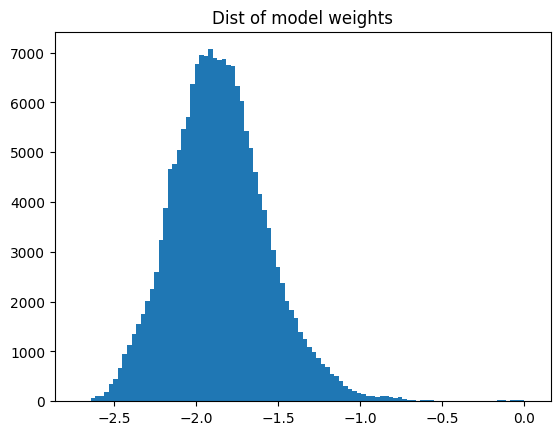

Outer epoch 90, Inner epoch 10, Loss: 	Avg Corr: 0.2544, Corr: 0.4495, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2589, Corr: 0.4394, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0228919982910156
Outer epoch 90, Inner epoch 20, Loss: 	Avg Corr: 0.2583, Corr: 0.4570, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2589, Corr: 0.4394, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0399096012115479
Outer epoch 90, Inner epoch 30, Loss: 	Avg Corr: 0.2580, Corr: 0.4570, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2589, Corr: 0.4394, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0400164127349854
Outer epoch 90, Inner epoch 40, Loss: 	Avg Corr: 0.2579, Corr: 0.4570, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2589, Corr: 0.4394, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0400748252868652
Outer epoch 90, Inner epoch 50, Loss: 	Avg Corr: 0.2579, Corr: 0.4573, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.258

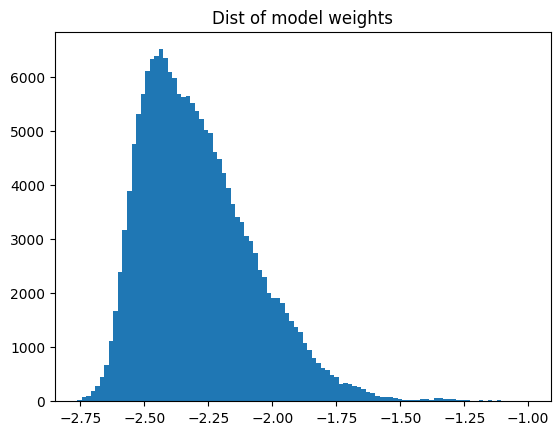

Outer epoch 91, Inner epoch 10, Loss: 	Avg Corr: 0.3552, Corr: 0.8623, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2566, Corr: 0.4345, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.9848685264587402
Outer epoch 91, Inner epoch 20, Loss: 	Avg Corr: 0.3592, Corr: 0.8745, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2566, Corr: 0.4345, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 2.01286244392395
Outer epoch 91, Inner epoch 30, Loss: 	Avg Corr: 0.3540, Corr: 0.8509, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2566, Corr: 0.4345, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.9585399627685547
Outer epoch 91, Inner epoch 40, Loss: 	Avg Corr: 0.3477, Corr: 0.8220, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2566, Corr: 0.4345, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.891932487487793
Outer epoch 91, Inner epoch 50, Loss: 	Avg Corr: 0.3373, Corr: 0.7828, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2566, 

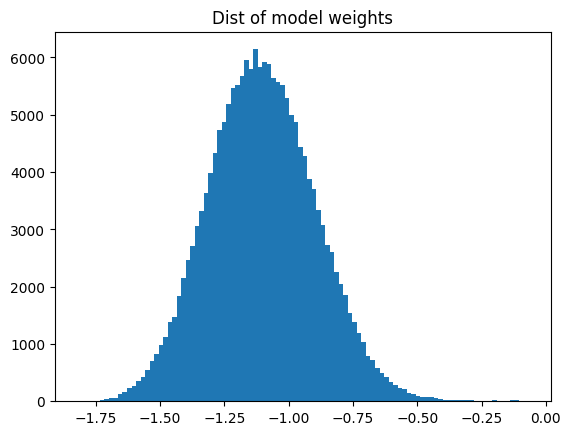

Outer epoch 92, Inner epoch 10, Loss: 	Avg Corr: 0.3944, Corr: 0.9395, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3444, Corr: 0.7347, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.278639554977417
Outer epoch 92, Inner epoch 20, Loss: 	Avg Corr: 0.3861, Corr: 0.9043, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3444, Corr: 0.7347, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.2307392358779907
Outer epoch 92, Inner epoch 30, Loss: 	Avg Corr: 0.3781, Corr: 0.8733, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3444, Corr: 0.7347, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1885886192321777
Outer epoch 92, Inner epoch 40, Loss: 	Avg Corr: 0.3733, Corr: 0.8526, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3444, Corr: 0.7347, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1604501008987427
Outer epoch 92, Inner epoch 50, Loss: 	Avg Corr: 0.3644, Corr: 0.8105, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3444

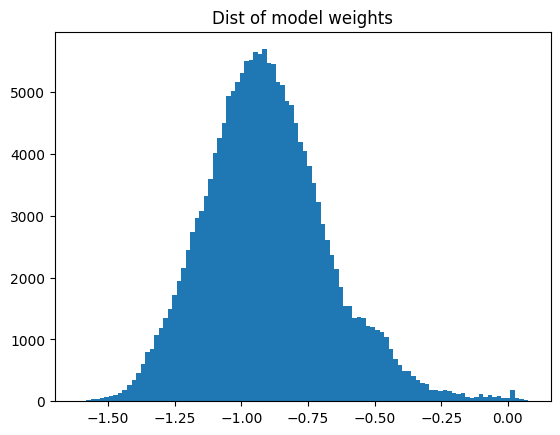

Outer epoch 93, Inner epoch 10, Loss: 	Avg Corr: 0.2771, Corr: 0.5021, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2889, Corr: 0.6529, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.7690253853797913
Outer epoch 93, Inner epoch 20, Loss: 	Avg Corr: 0.2813, Corr: 0.4991, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2889, Corr: 0.6529, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.7644680142402649
Outer epoch 93, Inner epoch 30, Loss: 	Avg Corr: 0.2790, Corr: 0.4887, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2889, Corr: 0.6529, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.7485394477844238
Outer epoch 93, Inner epoch 40, Loss: 	Avg Corr: 0.2788, Corr: 0.4867, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2889, Corr: 0.6529, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.7455037236213684
Outer epoch 93, Inner epoch 50, Loss: 	Avg Corr: 0.2784, Corr: 0.4854, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.288

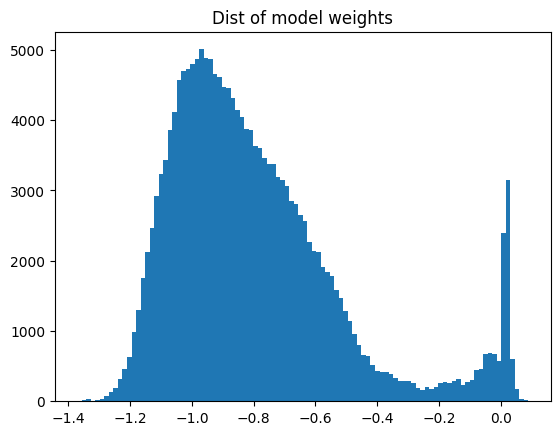

Outer epoch 94, Inner epoch 10, Loss: 	Avg Corr: 0.2160, Corr: 0.3104, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2452, Corr: 0.3859, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8044501543045044
Outer epoch 94, Inner epoch 20, Loss: 	Avg Corr: 0.2164, Corr: 0.3128, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2452, Corr: 0.3859, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.810563862323761
Outer epoch 94, Inner epoch 30, Loss: 	Avg Corr: 0.2157, Corr: 0.3110, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2452, Corr: 0.3859, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8058763742446899
Outer epoch 94, Inner epoch 40, Loss: 	Avg Corr: 0.2151, Corr: 0.3098, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2452, Corr: 0.3859, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8029021620750427
Outer epoch 94, Inner epoch 50, Loss: 	Avg Corr: 0.2145, Corr: 0.3081, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2452

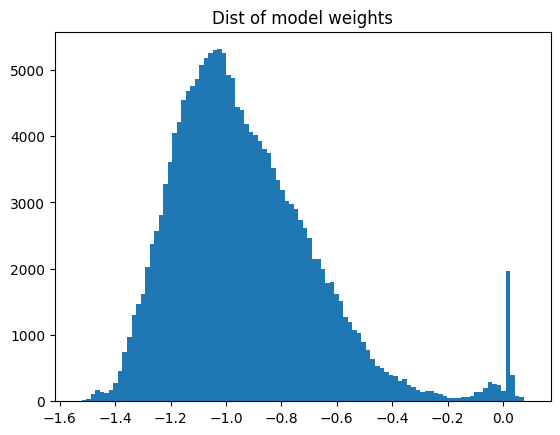

Outer epoch 95, Inner epoch 10, Loss: 	Avg Corr: 0.2939, Corr: 0.6057, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3052, Corr: 0.6344, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.954797089099884
Outer epoch 95, Inner epoch 20, Loss: 	Avg Corr: 0.2910, Corr: 0.6007, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3052, Corr: 0.6344, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9469304084777832
Outer epoch 95, Inner epoch 30, Loss: 	Avg Corr: 0.2866, Corr: 0.5890, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3052, Corr: 0.6344, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9285616278648376
Outer epoch 95, Inner epoch 40, Loss: 	Avg Corr: 0.2850, Corr: 0.5852, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3052, Corr: 0.6344, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9225688576698303
Outer epoch 95, Inner epoch 50, Loss: 	Avg Corr: 0.2871, Corr: 0.5910, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3052

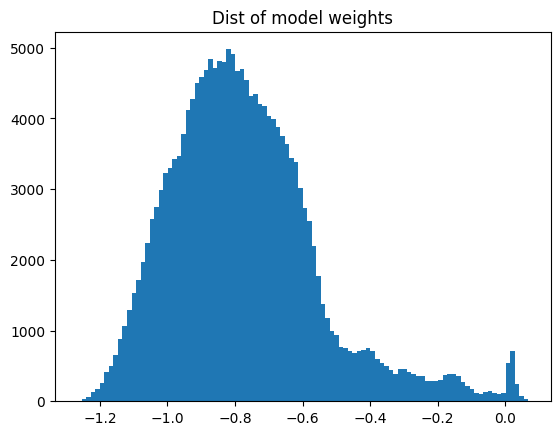

Outer epoch 96, Inner epoch 10, Loss: 	Avg Corr: 0.2448, Corr: 0.4573, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2806, Corr: 0.5253, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8704985976219177
Outer epoch 96, Inner epoch 20, Loss: 	Avg Corr: 0.2449, Corr: 0.4641, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2806, Corr: 0.5253, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8834547400474548
Outer epoch 96, Inner epoch 30, Loss: 	Avg Corr: 0.2451, Corr: 0.4672, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2806, Corr: 0.5253, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8894942402839661
Outer epoch 96, Inner epoch 40, Loss: 	Avg Corr: 0.2455, Corr: 0.4688, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2806, Corr: 0.5253, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8924122452735901
Outer epoch 96, Inner epoch 50, Loss: 	Avg Corr: 0.2450, Corr: 0.4698, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.280

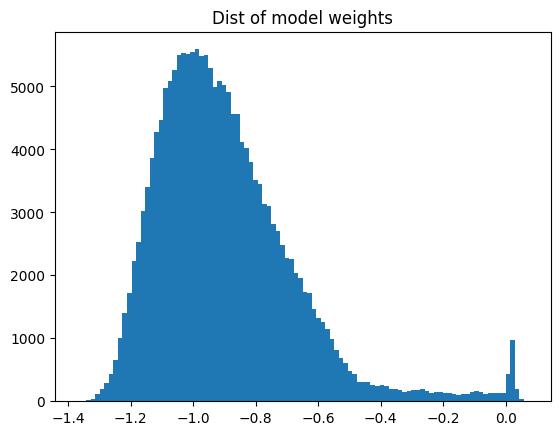

Outer epoch 97, Inner epoch 10, Loss: 	Avg Corr: 0.2749, Corr: 0.4993, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3094, Corr: 0.5751, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8681557774543762
Outer epoch 97, Inner epoch 20, Loss: 	Avg Corr: 0.2745, Corr: 0.5044, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3094, Corr: 0.5751, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8770829439163208
Outer epoch 97, Inner epoch 30, Loss: 	Avg Corr: 0.2793, Corr: 0.5225, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3094, Corr: 0.5751, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9084115028381348
Outer epoch 97, Inner epoch 40, Loss: 	Avg Corr: 0.2838, Corr: 0.5344, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3094, Corr: 0.5751, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.9292184710502625
Outer epoch 97, Inner epoch 50, Loss: 	Avg Corr: 0.2829, Corr: 0.5400, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.309

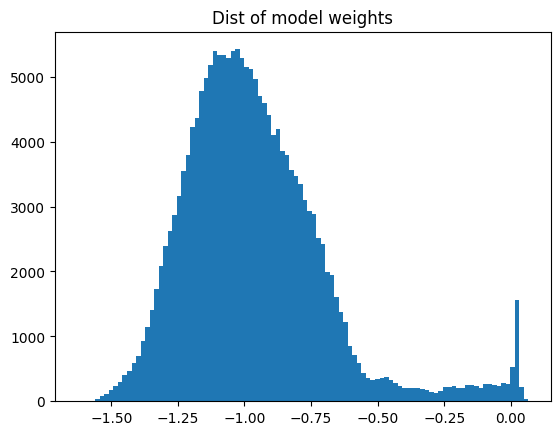

Outer epoch 98, Inner epoch 10, Loss: 	Avg Corr: 0.3355, Corr: 0.7360, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3581, Corr: 0.7171, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0263043642044067
Outer epoch 98, Inner epoch 20, Loss: 	Avg Corr: 0.3372, Corr: 0.7604, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3581, Corr: 0.7171, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0602859258651733
Outer epoch 98, Inner epoch 30, Loss: 	Avg Corr: 0.3363, Corr: 0.7640, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3581, Corr: 0.7171, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.065394401550293
Outer epoch 98, Inner epoch 40, Loss: 	Avg Corr: 0.3348, Corr: 0.7625, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3581, Corr: 0.7171, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0632082223892212
Outer epoch 98, Inner epoch 50, Loss: 	Avg Corr: 0.3314, Corr: 0.7577, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3581

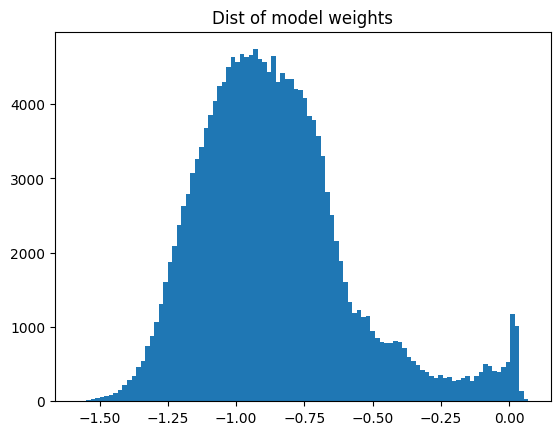

Outer epoch 99, Inner epoch 10, Loss: 	Avg Corr: 0.3379, Corr: 0.6928, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3784, Corr: 0.8183, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.846712589263916
Outer epoch 99, Inner epoch 20, Loss: 	Avg Corr: 0.3391, Corr: 0.6957, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3784, Corr: 0.8183, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8501847982406616
Outer epoch 99, Inner epoch 30, Loss: 	Avg Corr: 0.3372, Corr: 0.6881, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3784, Corr: 0.8183, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8409497737884521
Outer epoch 99, Inner epoch 40, Loss: 	Avg Corr: 0.3383, Corr: 0.6907, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3784, Corr: 0.8183, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 0.8440596461296082
Outer epoch 99, Inner epoch 50, Loss: 	Avg Corr: 0.3372, Corr: 0.6872, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3784

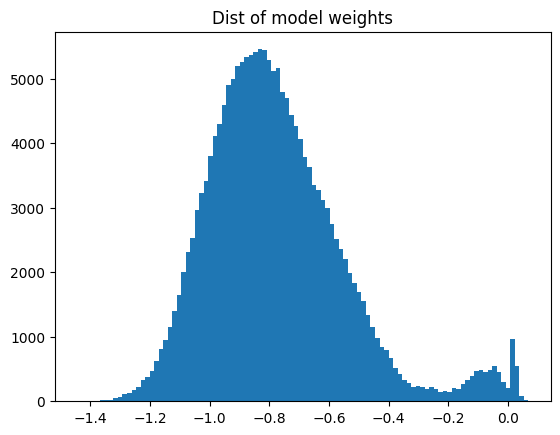

In [27]:
losses = train_model()

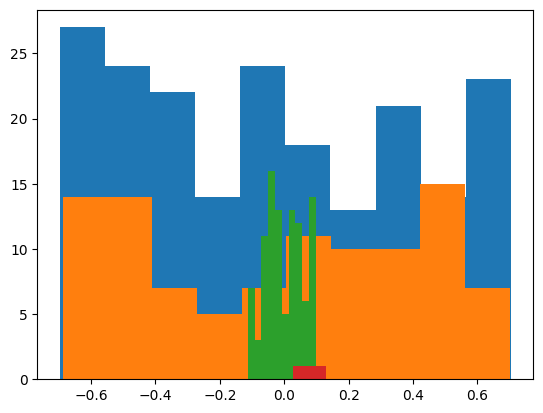

In [28]:
for param in model.parameters():
    with torch.no_grad():
        if torch.count_nonzero(param.isnan()) > 0:
            print(param)
        else:
            plt.hist(param.flatten())
            
plt.show()

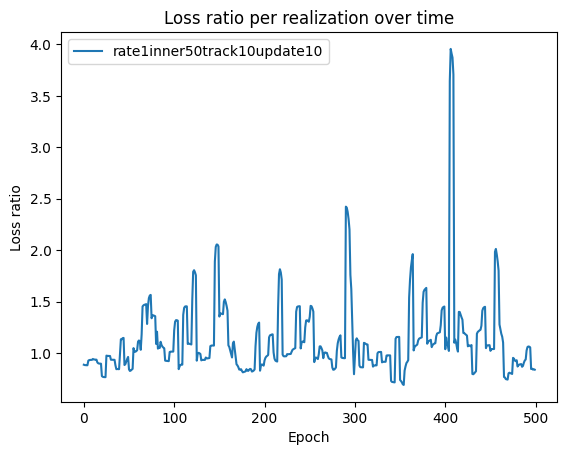

In [29]:
with torch.no_grad():
    # Regularization and weight decay
    # rate=-1, n_track=n_update=10 reduces correlations by 50%, better than rate=-2
    # Updating multiple times per epoch decreases loss below regular inner epoch formulation (if we set inner epochs = 50, only way to get it to decorrelate is to increase n_track and n_update)
    plt.plot(torch.arange(losses.shape[0]), losses, label="rate1inner50track10update10")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss ratio")
    plt.title("Loss ratio per realization over time")
    plt.show()

In [30]:
i = correlated_mitral_activity()
hbar_ff = compute_feedforward_activity(i)
W_random = compute_initial_recurrent_weights()
R_random = compute_piriform_response(hbar_ff, W_random, threshold_multiplier)

In [31]:
# Look at how weights evolve over the course of inner epoch, for a random realization
# Store a random set of 10 weights and see how the 10 weights change over the course of the iterations

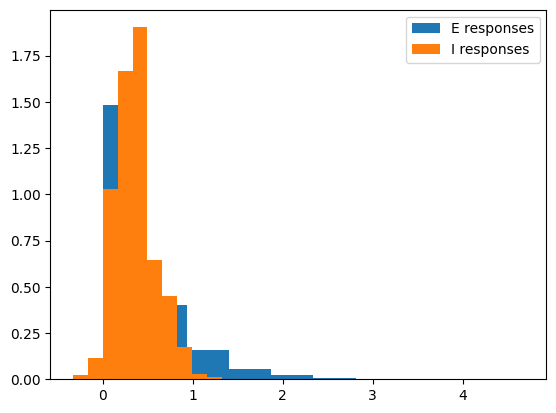

In [32]:
with torch.no_grad():
    plt.hist(torch.flatten(R_random[:num_e]), density=True, label="E responses")
    plt.hist(torch.flatten(R_random[num_e:]), density=True, label="I responses")
    plt.legend()
    plt.show()

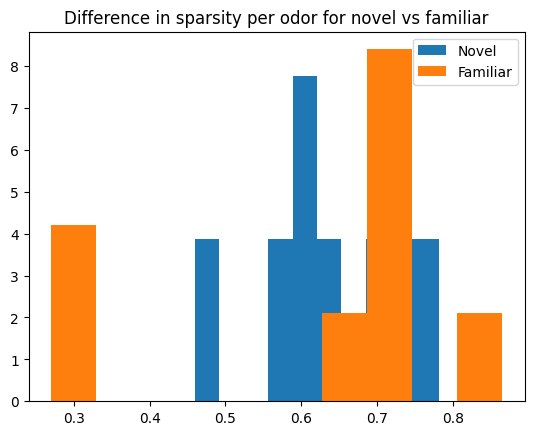

In [33]:
with torch.no_grad():
    sparsities = sparsity_per_odor(R_random)
    spars_novel = sparsities[novel_inds]
    spars_familiar = sparsities[familiar_inds]
    plt.hist(spars_novel, density=True, label="Novel")
    plt.hist(spars_familiar, density=True, label="Familiar")
    plt.title("Difference in sparsity per odor for novel vs familiar")
    plt.legend()
    plt.show()

In [34]:
# TODO add I to E training
# Save the model for each regime we test (so we can retrieve the colormap)
# Re-run it again or twice (just to verify model trains in same way)
# - First only train I to E (and keep E to I fixed, as sanity check)
# - First try w/o regularization term, then add it (functionality should be same as E to I)
# - Want weights to blow up negatively (such that E input would be very small and below ReLU threshold, so it creates sparsity concept)
# - Optimize it jointly to E to I (the W_ei weights will also have a gradient so we can update its model)
# Use a separate model
# Train it only on portion of responses the model actually sees (I: 0-1, E: 0-2)
# Make sure its not overfitting but that the R^2 is high enough
# Empirically looks like E^2 + I^2 (and changes faster in I direction)
# As sparsity regularization parameter changes, see how the regression parameters would change

In [35]:
#path = "./models/2"
#torch.save(model.state_dict(), path)
#model = create_model()
#model.load_state_dict(torch.load(path))

In [36]:
def make_colormap(model):
    num_ticks = 100
    E_min, E_max = torch.min(R_random[:num_e, :]), torch.max(R_random[:num_e, :])
    I_min, I_max = torch.min(R_random[num_e:, :]), torch.max(R_random[num_e:, :])
    E_vals = torch.linspace(E_min, E_max, num_ticks)
    I_vals = torch.linspace(I_min, I_max, num_ticks)
    I_coords, E_coords = torch.meshgrid(I_vals, E_vals, indexing="ij")
    R_plot = torch.stack((I_coords.flatten(), E_coords.flatten()), dim=1)
    with torch.no_grad():
        plasticity_vals = model(R_plot).squeeze(0)
        
    print(torch.count_nonzero(plasticity_vals.isnan()))
        
    plot = plt.scatter(R_plot[:, 0], R_plot[:, 1], c=plasticity_vals, cmap='rainbow')
    clrbar = plt.colorbar(plot)
    clrbar.set_label('Model plasticity')
    plt.title('I-E plasticity based on neural responses')
    plt.xlabel("I responses")
    plt.ylabel("E responses")
        
    return E_min, E_max, I_min, I_max, R_plot, plasticity_vals

tensor(0)


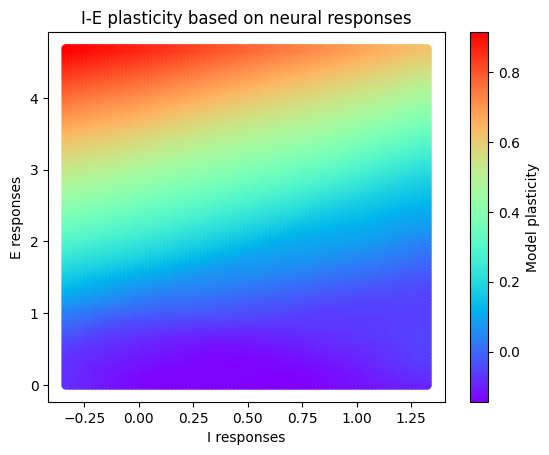

In [37]:
make_colormap(model)
print()
plt.show()

In [38]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

def fit_model(model, degree=3):
    E_min, E_max, I_min, I_max, R_plot, plasticity_vals = make_colormap(model)
    
    
    std = 2 # Take data within 2 std of responses mean
    mu_e = torch.mean(torch.flatten(R_random[:num_e]))
    sig_e = torch.std(torch.flatten(R_random[:num_e]))
    mu_i = torch.mean(torch.flatten(R_random[num_e:]))
    sig_i = torch.std(torch.flatten(R_random[num_e:]))
    e_train_bounds = (torch.max(E_min, mu_e - std*sig_e), torch.min(E_max, mu_e + std*sig_e))
    i_train_bounds = (torch.max(I_min, mu_i - std*sig_i), torch.min(I_max, mu_i + std*sig_i))
    
    reg = Pipeline([('poly', PolynomialFeatures(degree=degree)),
                  ('linear', LinearRegression(fit_intercept=False))])
    
    e_inds = torch.logical_and(torch.ge(R_plot[:, 0], i_train_bounds[0]), torch.le(R_plot[:, 0], i_train_bounds[1]))
    i_inds = torch.logical_and(torch.ge(R_plot[:, 1], e_train_bounds[0]), torch.le(R_plot[:, 1], e_train_bounds[1]))
    b = torch.logical_and(i_inds, e_inds)
    X = R_plot[b]
    y = plasticity_vals[b].squeeze(0)
    
    reg = reg.fit(X, y)
    # Exclude bias term
    coefs = reg.named_steps['linear'].coef_[0][1:]
    # How many terms to consider
    take = 3
    # Take largest magnitude terms
    inds = np.argsort(np.abs(coefs))[-take:]

    # Exclude bias term
    term_list = reg.named_steps['poly'].powers_[1:, :]
    terms = f"[I, E] powers:\n"
    for i in range(take - 1, -1, -1):
        term = f"{term_list[inds][i]}: {coefs[inds][i]}\n"
        terms += term
    
    print(terms)
    
    preds = reg.predict(X).ravel()
    return X, preds

tensor(0)
[I, E] powers:
[0 2]: 0.2115150565751338
[2 0]: 0.1429905236165724
[1 0]: -0.1075826173896967


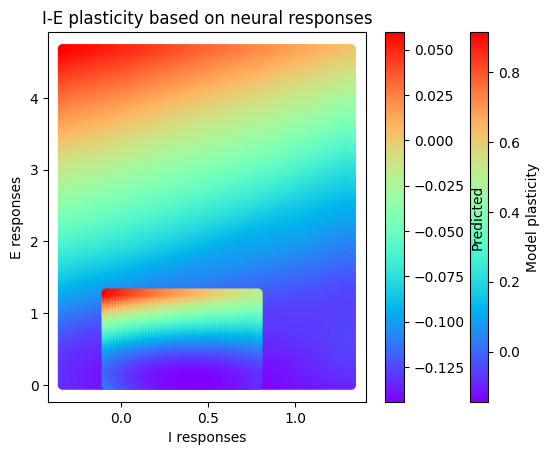

In [39]:
X, preds = fit_model(model, degree=3)

pred_plot = plt.scatter(X[:, 0], X[:, 1], c=preds, cmap='rainbow')
clrbar2 = plt.colorbar(pred_plot)
clrbar2.set_label('Predicted')
plt.xlabel("I responses")
plt.ylabel("E responses")
plt.show()

In [40]:
# Do a plot of rho_0 vs rho_final (for ex. 100 random initializations) to see whether the model can decorrelate odors
# Even though potentiation is always positive for the set of responses, since we are doing E to I, increasing the connection strength effectively increases inhibition too, so it balances out
# Not directly hebbian because that would mean there is some constant c*r_i*r_j, but when one of the responses is decreasing, the resulting potentiation doesn't decrease
# Instead, it will be an a * r_i + b * r_j term
# These terms come from the polynomial expansion of the function defined by the model

In [41]:
# Look at statistics of E neurons (mean firing rate across odors, variance, etc) at initialization compared to after plasticity
# Also look at sparsity - one across odors and another across neurons (sparsity is essentially 1 minus the square of the coefficient of variation)
# We care mostly about the sparsity across neurons (ex between neurons) and what it would be between odors (should be similar between the familiar odors b/c that's where we applied the plasticity) and we also know what it's like between novel odors
# We don't want a change in firing rate, because it should be same for novel and familiar odors

In [42]:
def verification_set(model, runs=20):
    corrs = torch.empty((runs,))
    ratios = torch.empty((runs,))
    spars_change = torch.empty((runs,))
    for i in range(runs):
        I_ff = correlated_mitral_activity()
        hbar_ff = compute_feedforward_activity(I_ff)
        W_random = compute_initial_recurrent_weights()
        R_random = compute_piriform_response(hbar_ff, W_random, threshold_multiplier)
        _, initial_corr = odor_corrs(R_random)
        spars_initial = sparsity_per_odor(R_random)
        initial_spars_diff = torch.abs(torch.mean(spars_initial[novel_inds]) - torch.mean(spars_initial[familiar_inds]))
        
        post = (0, num_e)
        pre = (num_e, num_neurons)
        weights_slice = W_random[post[0]:post[1], pre[0]:pre[1]]
        inds = torch.nonzero(weights_slice, as_tuple=True)
        update_inds = (inds[0] + post[0], inds[1] + pre[0])
        
        for _ in range(n_inner):
            _, W_random, R_random = loss_after_odors(model, W_random, R_random, hbar_ff, threshold_multiplier, plasticity_rate, weight_decay, update_inds, lambda_corr, lambda_mu, lambda_var, lambda_sp, detach_grad=True, with_loss=False)
        
        _, final_corr = odor_corrs(R_random)
        ratio = final_corr / initial_corr
        spars_final = sparsity_per_odor(R_random)
        # Plot actual difference in the sparsity number, not the percent change ratio
        # - Also see whether 
        final_spars_diff = torch.abs(torch.mean(spars_final[novel_inds]) - torch.mean(spars_final[familiar_inds]))
        
        print(f"Corr: {initial_corr} -> {final_corr}, Sparsity: {initial_spars_diff} -> {final_spars_diff}, Loss Ratio: {ratio}")
        corrs[i] = final_corr
        ratios[i] = ratio
        spars_change[i] = ((final_spars_diff - initial_spars_diff) / initial_spars_diff) * 100
        
    return corrs, ratios, spars_change

In [43]:
with torch.no_grad():
    corrs, ratios, spars_change = verification_set(model, runs=10)

Corr: 0.2268407940864563 -> 0.22063490748405457, Sparsity: 0.12251287698745728 -> 0.23487773537635803, Loss Ratio: 0.9726421236991882
Corr: 0.3014892339706421 -> 0.28081434965133667, Sparsity: 0.02410370111465454 -> 0.05874991416931152, Loss Ratio: 0.9314241409301758
Corr: 0.33658769726753235 -> 0.2821781635284424, Sparsity: 0.015932083129882812 -> 0.007486522197723389, Loss Ratio: 0.8383495807647705
Corr: 0.2834150791168213 -> 0.2697490453720093, Sparsity: 0.05602896213531494 -> 0.07374364137649536, Loss Ratio: 0.9517808556556702
Corr: 0.26966241002082825 -> 0.29553109407424927, Sparsity: 0.0044228434562683105 -> 0.11962291598320007, Loss Ratio: 1.0959298610687256
Corr: 0.27903053164482117 -> 0.2568565607070923, Sparsity: 0.097301185131073 -> 0.09271681308746338, Loss Ratio: 0.9205321073532104
Corr: 0.3709395229816437 -> 0.3895208537578583, Sparsity: 0.10978269577026367 -> 0.23381558060646057, Loss Ratio: 1.0500925779342651
Corr: 0.26211461424827576 -> 0.35756412148475647, Sparsity: 0

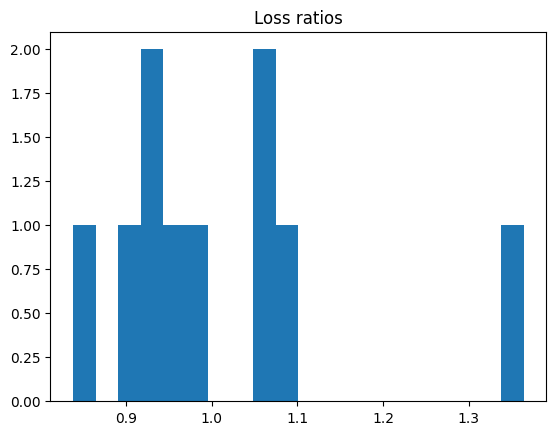

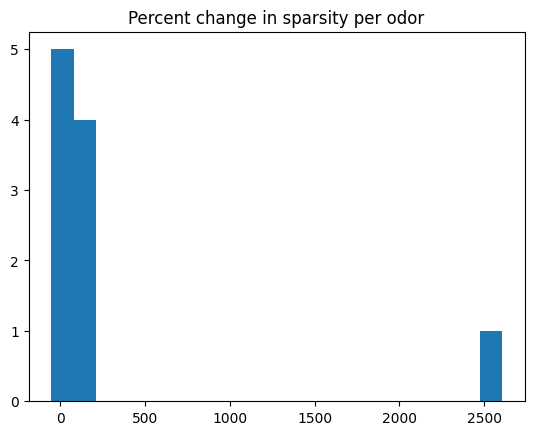

In [44]:
plt.hist(ratios, bins=20)
plt.title("Loss ratios")
plt.show()
plt.hist(spars_change, bins=20)
plt.title("Percent change in sparsity per odor")
plt.show()

In [45]:
spars_change[spars_change < 100]

tensor([ 91.7168, -53.0098,  31.6170,  -4.7115,  56.8081,  33.2454,  82.1819])

In [46]:
# Stats at initialization
i = correlated_mitral_activity()
hbar_ff = compute_feedforward_activity(i)
with torch.no_grad():
    W_random = compute_initial_recurrent_weights()
    R_random = compute_piriform_response(hbar_ff, W_random, threshold_multiplier)
mu_familiar_0 = torch.mean(R_random[:num_e, familiar_inds], dim=1)
sig_familiar_0 = torch.var(R_random[:num_e, familiar_inds], dim=1)
mu_novel_0 = torch.mean(R_random[:num_e, novel_inds], dim=1)
sig_novel_0 = torch.var(R_random[:num_e, novel_inds], dim=1)
#print(f"Initialization: \nFamiliar -  mean: {mu_familiar_0}, var: {sig_familiar_0}\nNovel -  mean: {mu_novel_0}, var: {sig_novel_0}")

In [47]:
# Stats after plasticity
W_plastic = W_random.detach().clone()
R_plastic = R_random.detach().clone()
post = (0, num_e)
pre = (num_e, num_neurons)
weights_slice = W_random[post[0]:post[1], pre[0]:pre[1]]
inds = torch.nonzero(weights_slice, as_tuple=True)
update_inds = (inds[0] + post[0], inds[1] + pre[0])

# Number of weights to track
num_samples = 100
W_tracked = torch.empty((n_inner, num_samples))
with torch.no_grad():
    for i in range(n_inner):
        _, W_plastic, R_plastic = loss_after_odors(model, W_plastic, R_plastic, hbar_ff, threshold_multiplier, plasticity_rate, weight_decay, update_inds, lambda_corr, lambda_mu, lambda_var, lambda_sp, detach_grad=True, with_loss=False)
        track_inds = torch.randint(0, len(update_inds), size=(num_samples,))
        W_tracked[i, :] = W_plastic[update_inds][track_inds].detach()
        
mu_familiar_f = torch.mean(R_plastic[:num_e, familiar_inds], dim=1)
sig_familiar_f = torch.var(R_plastic[:num_e, familiar_inds], dim=1)
mu_novel_f = torch.mean(R_plastic[:num_e, novel_inds], dim=1)
sig_novel_f = torch.var(R_plastic[:num_e, novel_inds], dim=1)
mu_novel_diff = mu_novel_f - mu_novel_0
mu_familiar_diff = mu_familiar_f - mu_familiar_0
sig_novel_diff = sig_novel_f - sig_novel_0
sig_familiar_diff = sig_familiar_f - sig_familiar_0

(array([  551.,  7061., 27833., 51855., 46579., 19428.,  8482.,  6593.,
         6856.,  5160.]),
 array([-1.07241631, -0.95629793, -0.84017956, -0.72406119, -0.60794282,
        -0.49182445, -0.37570608, -0.25958771, -0.14346932, -0.02735095,
         0.08876742]),
 <BarContainer object of 10 artists>)

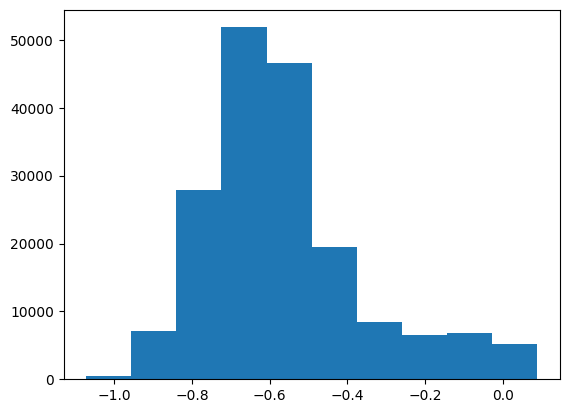

In [48]:
plt.hist(W_plastic[update_inds])

(array([ 180398.,       0., 3799611.,       0.,       0.,       0.,
              0.,       0.,       0.,   19991.]),
 array([-0.2       , -0.13      , -0.06      ,  0.01      ,  0.08      ,
         0.15000001,  0.22      ,  0.28999999,  0.36000001,  0.43000001,
         0.5       ]),
 <BarContainer object of 10 artists>)

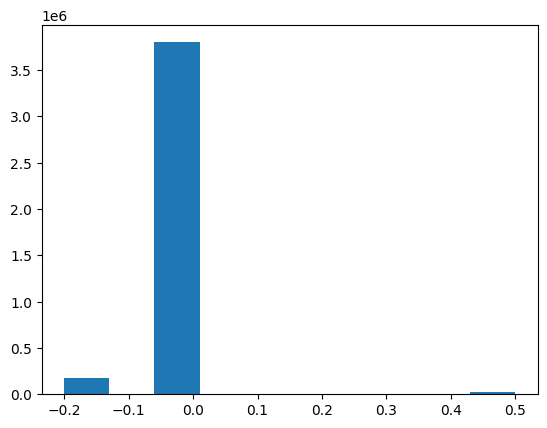

In [49]:
plt.hist(W_random.flatten())

In [50]:
torch.unique(W_plastic.flatten())

tensor([-1.0724, -1.0631, -1.0627,  ...,  0.0809,  0.0888,  0.5000])

In [51]:
with torch.no_grad():
    loss_fn(R_random, lambda_corr, lambda_mu, lambda_var, lambda_sp)
    loss_fn(R_plastic, lambda_corr, lambda_mu, lambda_var, lambda_sp)

Avg Corr: 0.2921, Corr: 0.5491, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.3109, Corr: 0.6320, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000


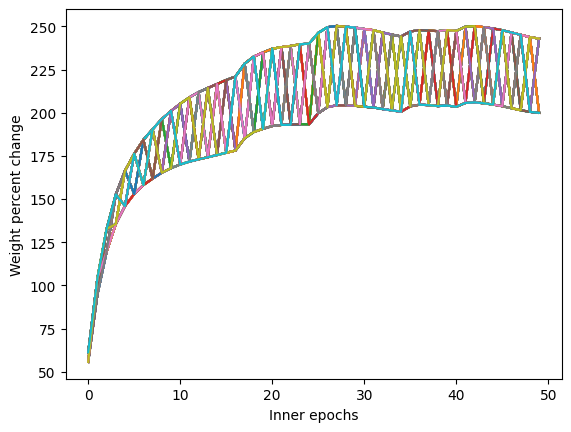

In [52]:
with torch.no_grad():
    pct_change = ((W_tracked - w_ei) / w_ei) * 100
    plt.plot(pct_change)
    plt.xlabel("Inner epochs")
    plt.ylabel("Weight percent change")

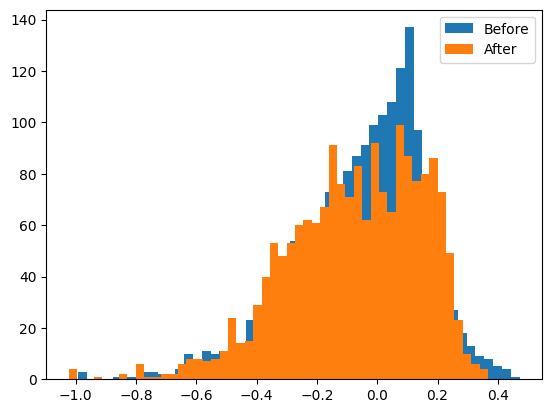

In [53]:
plt.hist(mu_familiar_0 - mu_novel_0, bins=50, label="Before")
plt.hist(mu_familiar_f - mu_novel_f, bins=50, label="After")
plt.legend()
plt.show()

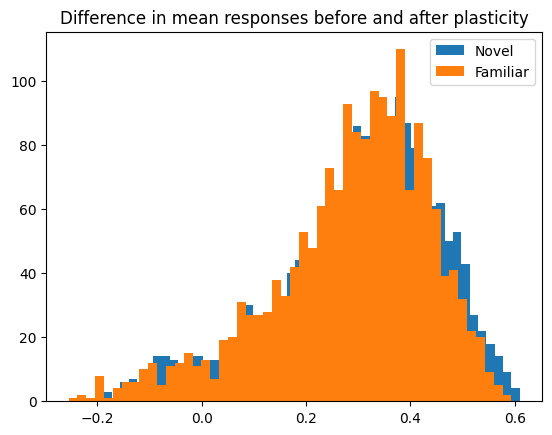

In [54]:
plt.hist(mu_novel_diff, bins=50, label="Novel")
plt.hist(mu_familiar_diff, bins=50, label="Familiar")
plt.title("Difference in mean responses before and after plasticity")
plt.legend()
plt.show()
# TODO find difference in familiar and novel (before plasticity) and then compare to diff (after plasticity)

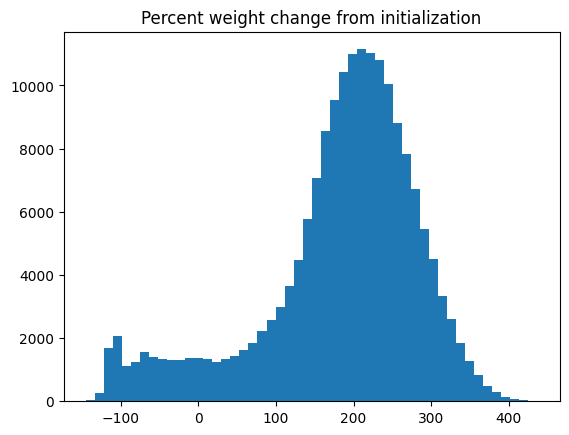

In [55]:
W_change = ((W_plastic[update_inds] - W_random[update_inds]) / W_random[update_inds]) * 100
plt.hist(W_change, bins=50)
plt.title("Percent weight change from initialization")
plt.show()
# Most weight 

In [56]:
sp_novel_0 = sparsity_per_neuron(R_random, novel_inds)
sp_novel_f = sparsity_per_neuron(R_plastic, novel_inds)
sp_familiar_0 = sparsity_per_neuron(R_random, familiar_inds)
sp_familiar_f = sparsity_per_neuron(R_plastic, familiar_inds)

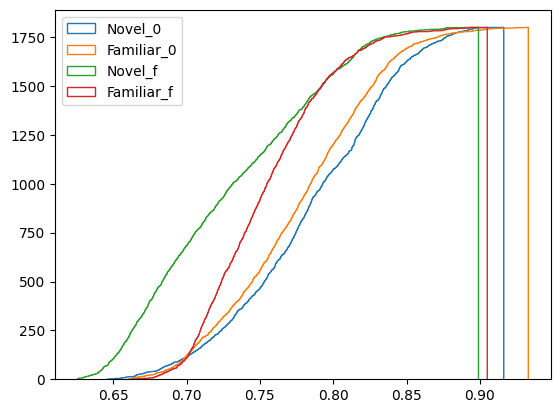

In [57]:
with torch.no_grad():
    plt.hist(sp_novel_0, cumulative=True, bins=num_e, histtype="step", label="Novel_0")
    plt.hist(sp_familiar_0, cumulative=True, bins=num_e, histtype="step", label="Familiar_0")
    plt.hist(sp_novel_f, cumulative=True, bins=num_e, histtype="step", label="Novel_f")
    plt.hist(sp_familiar_f, cumulative=True, bins=num_e, histtype="step", label="Familiar_f")
    plt.legend()
    plt.show()

In [58]:
# Create scatter plot of odor correlation vs sparsity difference - odors that are highly positively correlated should have similar sparsities across neurons, and those that are highly negatively correlated should have different sparsities across neurons
# Check - increase P' all the way to 16, and with lower correlations, there should be less variability between the sparsity for each odor
# - would tell us how much the natural spread in sparsity is

In [59]:
# 1. Re-run model w/ lower threshold (0 stdev above mean)
# 2. Figure out percentage-wise how much the weights actually change (do a hist)
# - if it's 1-2% it's too small, we want the weights to change 10-100%, the weights could even change 10-fold
# 3. Add metrics to training function - automatically compute sparsity etc (also look at the sparsity between odors, not just the sparsity between neurons, see if it changes for novel vs familiar)
# Create bar plot for each number of odors, how many neurons respond to that number of odors (ideally, if we have a threshold of 0 stdev, most neurons should respond to ~4 odors, since on average a neuron will respond to half of the total odors, so 8 odors, and out of those, it should be equal between 4 novel and 4 familiar)
# Hypothesis right now - weights aren't changing that much, so we can add more epoch_inner steps (since the gradient isn't blowing up)
# Then, try removing plasticity ramp - keep 1e-3 (don't do epoch_inner increase and remove plasticity ramp at same time)
# Goal: understand what mechanism the meta-learning discovered that makes correlations smaller (see whether it acts on sparsity etc)
# Think of other metrics to quantify network behavior to understand change